In [5]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import albumentations as A
import time
from tqdm import tqdm

In [6]:
# Paths to files

obj_dict = {
    1: {'folder': 'blush_brush', 'longest_min': 150, 'longest_max':800},
    2: {'folder': 'foundation_brush', 'longest_min': 150, 'longest_max':800},
    3: {'folder': 'highlighter_brush', 'longest_min': 150, 'longest_max':800},
    4: {'folder': 'powder_brush', 'longest_min': 150, 'longest_max':800}
}

In [7]:
PATH_MAIN = 'data'

for k, _ in obj_dict.items():
    folder_name = obj_dict[k]['folder']
    
    files_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'images')))
    files_imgs = [os.path.join(PATH_MAIN, folder_name, 'images', f) for f in files_imgs]
    
    files_masks = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'masks')))
    files_masks = [os.path.join(PATH_MAIN, folder_name, 'masks', f) for f in files_masks]
    
    obj_dict[k]['images'] = files_imgs
    obj_dict[k]['masks'] = files_masks
    
print('The first five files from the sorted list of blush brush images:', obj_dict[1]['images'][:5])
print('\nThe first five files from the sorted list of blush brush masks:', obj_dict[1]['masks'][:5])

files_bg_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, 'bg')))
files_bg_imgs = [os.path.join(PATH_MAIN, 'bg', f) for f in files_bg_imgs]
files_bg_imgs = [x for x in files_bg_imgs if x.endswith(".jpg")]

files_bg_noise_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, 'bg_noise', 'images')))
files_bg_noise_imgs = [os.path.join(PATH_MAIN, 'bg_noise', 'images', f) for f in files_bg_noise_imgs]
files_bg_noise_imgs = [x for x in files_bg_noise_imgs if x.endswith(".jpg")]


files_bg_noise_masks = sorted(os.listdir(os.path.join(PATH_MAIN, 'bg_noise', 'masks')))
files_bg_noise_masks = [os.path.join(PATH_MAIN, 'bg_noise', 'masks', f) for f in files_bg_noise_masks]
files_bg_noise_masks = [x for x in files_bg_noise_masks if x.endswith(".jpg")]

print('\nThe first five files from the sorted list of background images:', files_bg_imgs[:5])
print('\nThe first five files from the sorted list of background noise images:', files_bg_noise_imgs[:5])
print('\nThe first five files from the sorted list of background noise masks:', files_bg_noise_masks[:5])

The first five files from the sorted list of blush brush images: ['data/blush_brush/images/1.jpg', 'data/blush_brush/images/10.jpg', 'data/blush_brush/images/11.jpg', 'data/blush_brush/images/12.jpg', 'data/blush_brush/images/13.jpg']

The first five files from the sorted list of blush brush masks: ['data/blush_brush/masks/1.jpg', 'data/blush_brush/masks/10.jpg', 'data/blush_brush/masks/11.jpg', 'data/blush_brush/masks/12.jpg', 'data/blush_brush/masks/13.jpg']

The first five files from the sorted list of background images: ['data/bg/1.jpg', 'data/bg/10.jpg', 'data/bg/11.jpg', 'data/bg/12.jpg', 'data/bg/13.jpg']

The first five files from the sorted list of background noise images: ['data/bg_noise/images/1.jpg', 'data/bg_noise/images/10.jpg', 'data/bg_noise/images/100.jpg', 'data/bg_noise/images/101.jpg', 'data/bg_noise/images/102.jpg']

The first five files from the sorted list of background noise masks: ['data/bg_noise/masks/1.jpg', 'data/bg_noise/masks/10.jpg', 'data/bg_noise/masks/

In [8]:
# Function that returns an image of the object in and OpenCV format
# and its mask


def get_img_and_mask(img_path, mask_path):
    print(">>>", img_path, " :: ", mask_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    
    mask_b = mask[:,:,0] == 0 # This is boolean mask
    mask = mask_b.astype(np.uint8) # This is binary mask
    
    return img, mask

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
Image file: data/highlighter_brush/images/1.jpg
Mask file: data/highlighter_brush/masks/1.jpg

Shape of the image of the object: (1200, 1200, 3)
Shape of the binary mask: (1200, 1200)


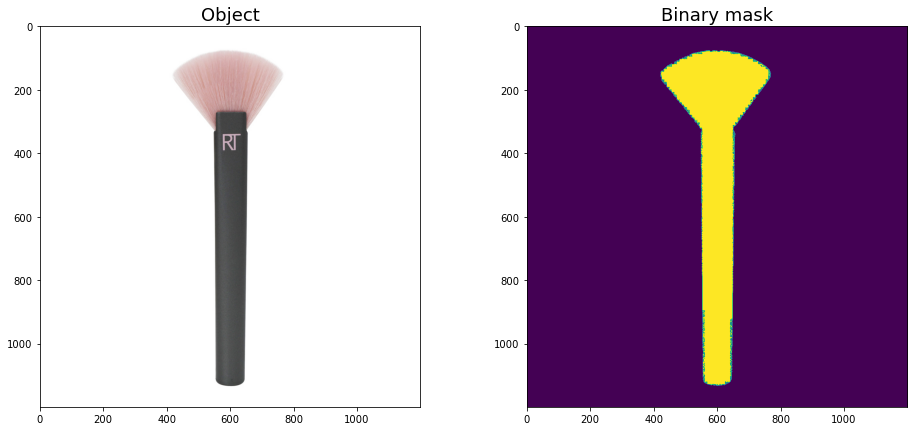

In [9]:
# Let's look at a random object and its binary mask 

img_path = obj_dict[3]['images'][0]
mask_path = obj_dict[3]['masks'][0]

img, mask = get_img_and_mask(img_path, mask_path)

print("Image file:", img_path)
print("Mask file:", mask_path)
print("\nShape of the image of the object:", img.shape)
print("Shape of the binary mask:", mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Binary mask', fontsize=18);

In [10]:
# Resizing background images

def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

Shape of the original background image: (1280, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=None): (1280, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=1080): (1080, 1920, 3)


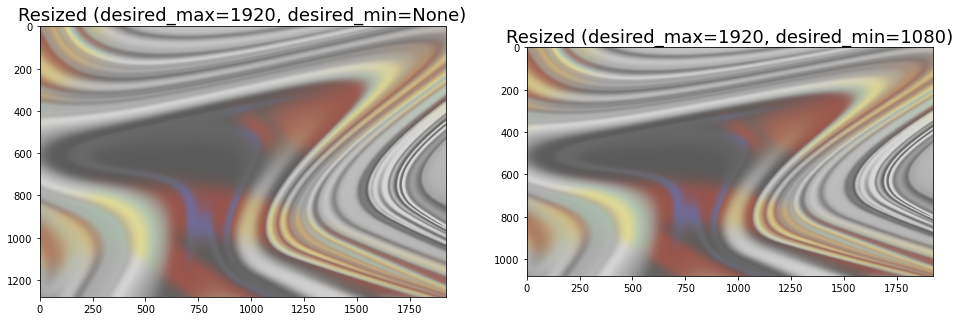

In [11]:
# Let's look how a random background image can be resized with resize_img() function

img_bg_path = files_bg_imgs[5]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=1920, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=1920, desired_min=1080):", img_bg_resized_2.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Resized (desired_max=1920, desired_min=None)', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Resized (desired_max=1920, desired_min=1080)', fontsize=18);

In [12]:
# Resizing and transforming objects
"""
Resizes image of the object and mask of the object.
Also, transforms from albumentations library can be passed to the function as argument
"""

def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t

transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3,
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.5)
])

transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])


>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
Shape of the image of the transformed object: (346, 346, 3)
Shape of the transformed binary mask: (346, 346)




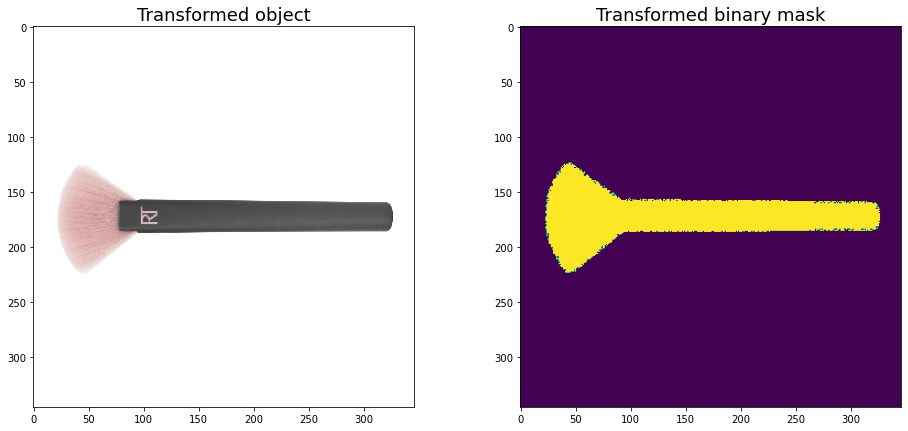

In [13]:
# Let's look how image and mask of a random object can be transformed
# with help of resize_transform_obj() function

img_path = obj_dict[3]['images'][0]
mask_path = obj_dict[3]['masks'][0]

img, mask = get_img_and_mask(img_path, mask_path)

img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     longest_min=300,
                                     longest_max=400,
                                     transforms=transforms_obj)

print("Shape of the image of the transformed object:", img_t.shape)
print("Shape of the transformed binary mask:", mask_t.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_t)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(mask_t)
ax[1].set_title('Transformed binary mask', fontsize=18);

In [14]:
# Adding object to background

def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added                             

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg


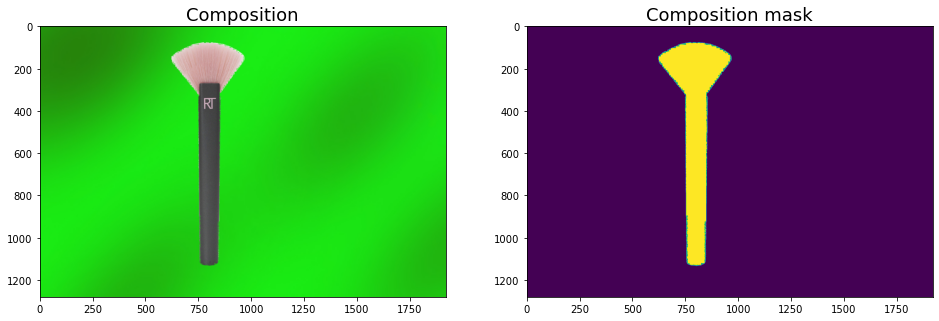

In [15]:
# Adding image to background

img_bg_path = files_bg_imgs[26]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

h, w = img_bg.shape[0], img_bg.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)

img_path = obj_dict[3]['images'][0]
mask_path = obj_dict[3]['masks'][0]
img, mask = get_img_and_mask(img_path, mask_path)

img_comp, mask_comp, _ = add_obj(img_bg, mask_comp, img, mask, x=800, y=600, idx=1)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);


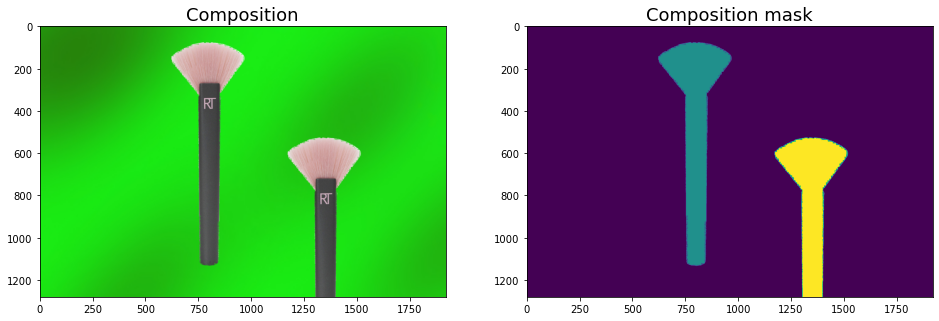

In [16]:
img_comp, mask_comp, _ = add_obj(img_comp, mask_comp, img, mask, x=1350, y=1050, idx=2)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

In [17]:
# Adding noise objects to background

def create_bg_with_noise(files_bg_imgs,
                         files_bg_noise_imgs,
                         files_bg_noise_masks,
                         bg_max=1920,
                         bg_min=1080,
                         max_objs_to_add=60,
                         longest_bg_noise_max=1000,
                         longest_bg_noise_min=200,
                         blank_bg=False):
    
    if blank_bg:
        img_comp_bg = np.ones((bg_min, bg_max,3), dtype=np.uint8) * 255
        mask_comp_bg = np.zeros((bg_min, bg_max), dtype=np.uint8)
    else:    
        idx = np.random.randint(len(files_bg_imgs))
        img_bg = cv2.imread(files_bg_imgs[idx])
        img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
        img_comp_bg = resize_img(img_bg, bg_max, bg_min)
        mask_comp_bg = np.zeros((img_comp_bg.shape[0], img_comp_bg.shape[1]), dtype=np.uint8)

    for i in range(1, np.random.randint(max_objs_to_add) + 2):

        idx = np.random.randint(len(files_bg_noise_imgs))
        img, mask = get_img_and_mask(files_bg_noise_imgs[idx], files_bg_noise_masks[idx])
        x, y = np.random.randint(img_comp_bg.shape[1]), np.random.randint(img_comp_bg.shape[0])
        img_t, mask_t = resize_transform_obj(img, mask, longest_bg_noise_min, longest_bg_noise_max, transforms=transforms_bg_obj)
        img_comp_bg, _, _ = add_obj(img_comp_bg, mask_comp_bg, img_t, mask_t, x, y, i)
        
    return img_comp_bg

>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/42.jpg  ::  data/

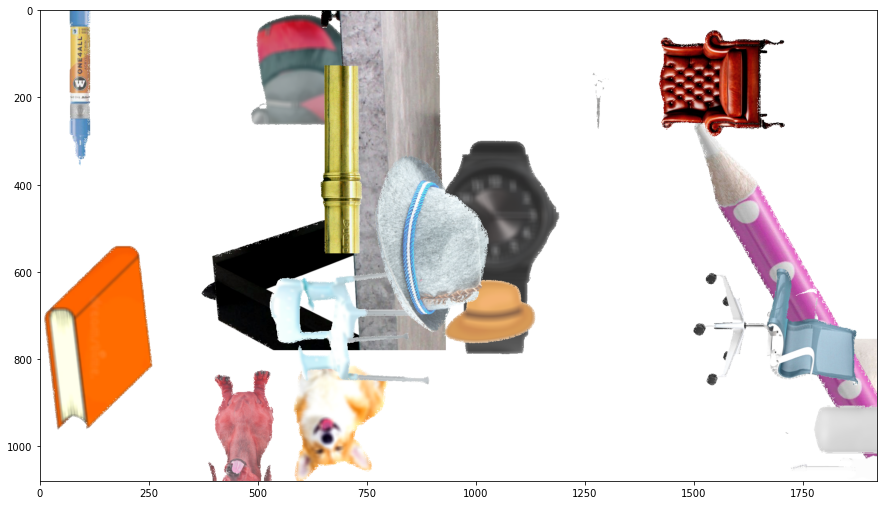

In [18]:
img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                   files_bg_noise_imgs,
                                   files_bg_noise_masks,
                                   max_objs_to_add=20,
                                   blank_bg=True)
plt.figure(figsize=(15,15))
plt.imshow(img_comp_bg)

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg


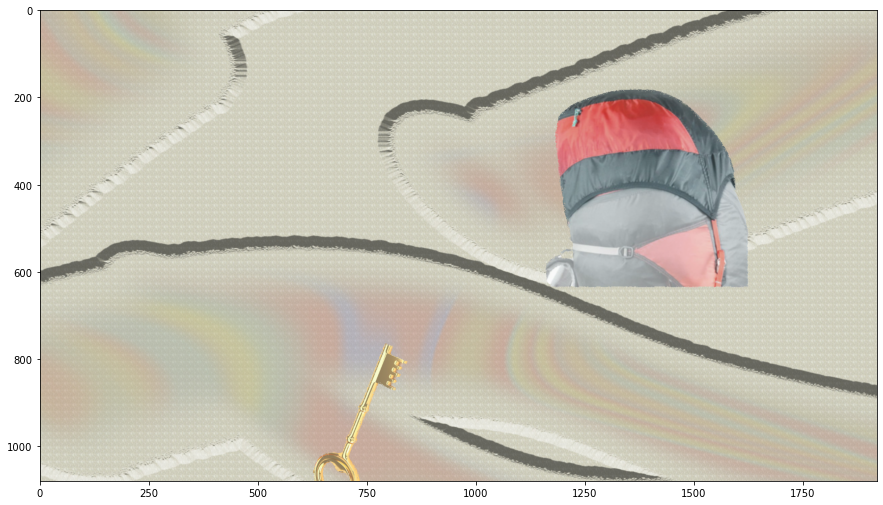

In [19]:
img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                   files_bg_noise_imgs,
                                   files_bg_noise_masks,
                                   max_objs_to_add=20)
plt.figure(figsize=(15,15))
plt.imshow(img_comp_bg)

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg


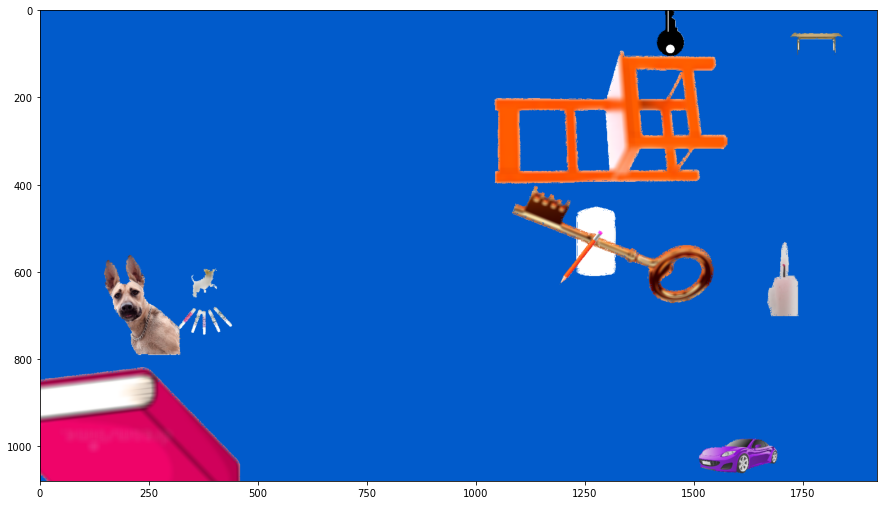

In [20]:
img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                   files_bg_noise_imgs,
                                   files_bg_noise_masks,
                                   max_objs_to_add=20)
plt.figure(figsize=(15,15))
plt.imshow(img_comp_bg)

In [21]:
# Controlling degree of overlapping
def check_areas(mask_comp, obj_areas, overlap_degree=0.3):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok   

In [22]:
def create_composition(img_comp_bg,
                       max_objs=15,
                       overlap_degree=0.2,
                       max_attempts_per_obj=10):

    img_comp = img_comp_bg.copy()
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8)
    
    obj_areas = []
    labels_comp = []
    num_objs = np.random.randint(max_objs) + 2
    
    i = 1
    
    for _ in range(1, num_objs):

        obj_idx = np.random.randint(len(obj_dict)) + 1
        
        for _ in range(max_attempts_per_obj):

            imgs_number = len(obj_dict[obj_idx]['images'])
            idx = np.random.randint(imgs_number)
            img_path = obj_dict[obj_idx]['images'][idx]
            mask_path = obj_dict[obj_idx]['masks'][idx]
            img, mask = get_img_and_mask(img_path, mask_path)

            x, y = np.random.randint(w), np.random.randint(h)
            longest_min = obj_dict[obj_idx]['longest_min']
            longest_max = obj_dict[obj_idx]['longest_max']
            img, mask = resize_transform_obj(img,
                                             mask,
                                             longest_min,
                                             longest_max,
                                             transforms=transforms_obj)

            if i == 1:
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(obj_idx)
                i += 1
                break
            else:        
                img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_added))
                    labels_comp.append(obj_idx)
                    i += 1
                    break
                else:
                    img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas

>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg


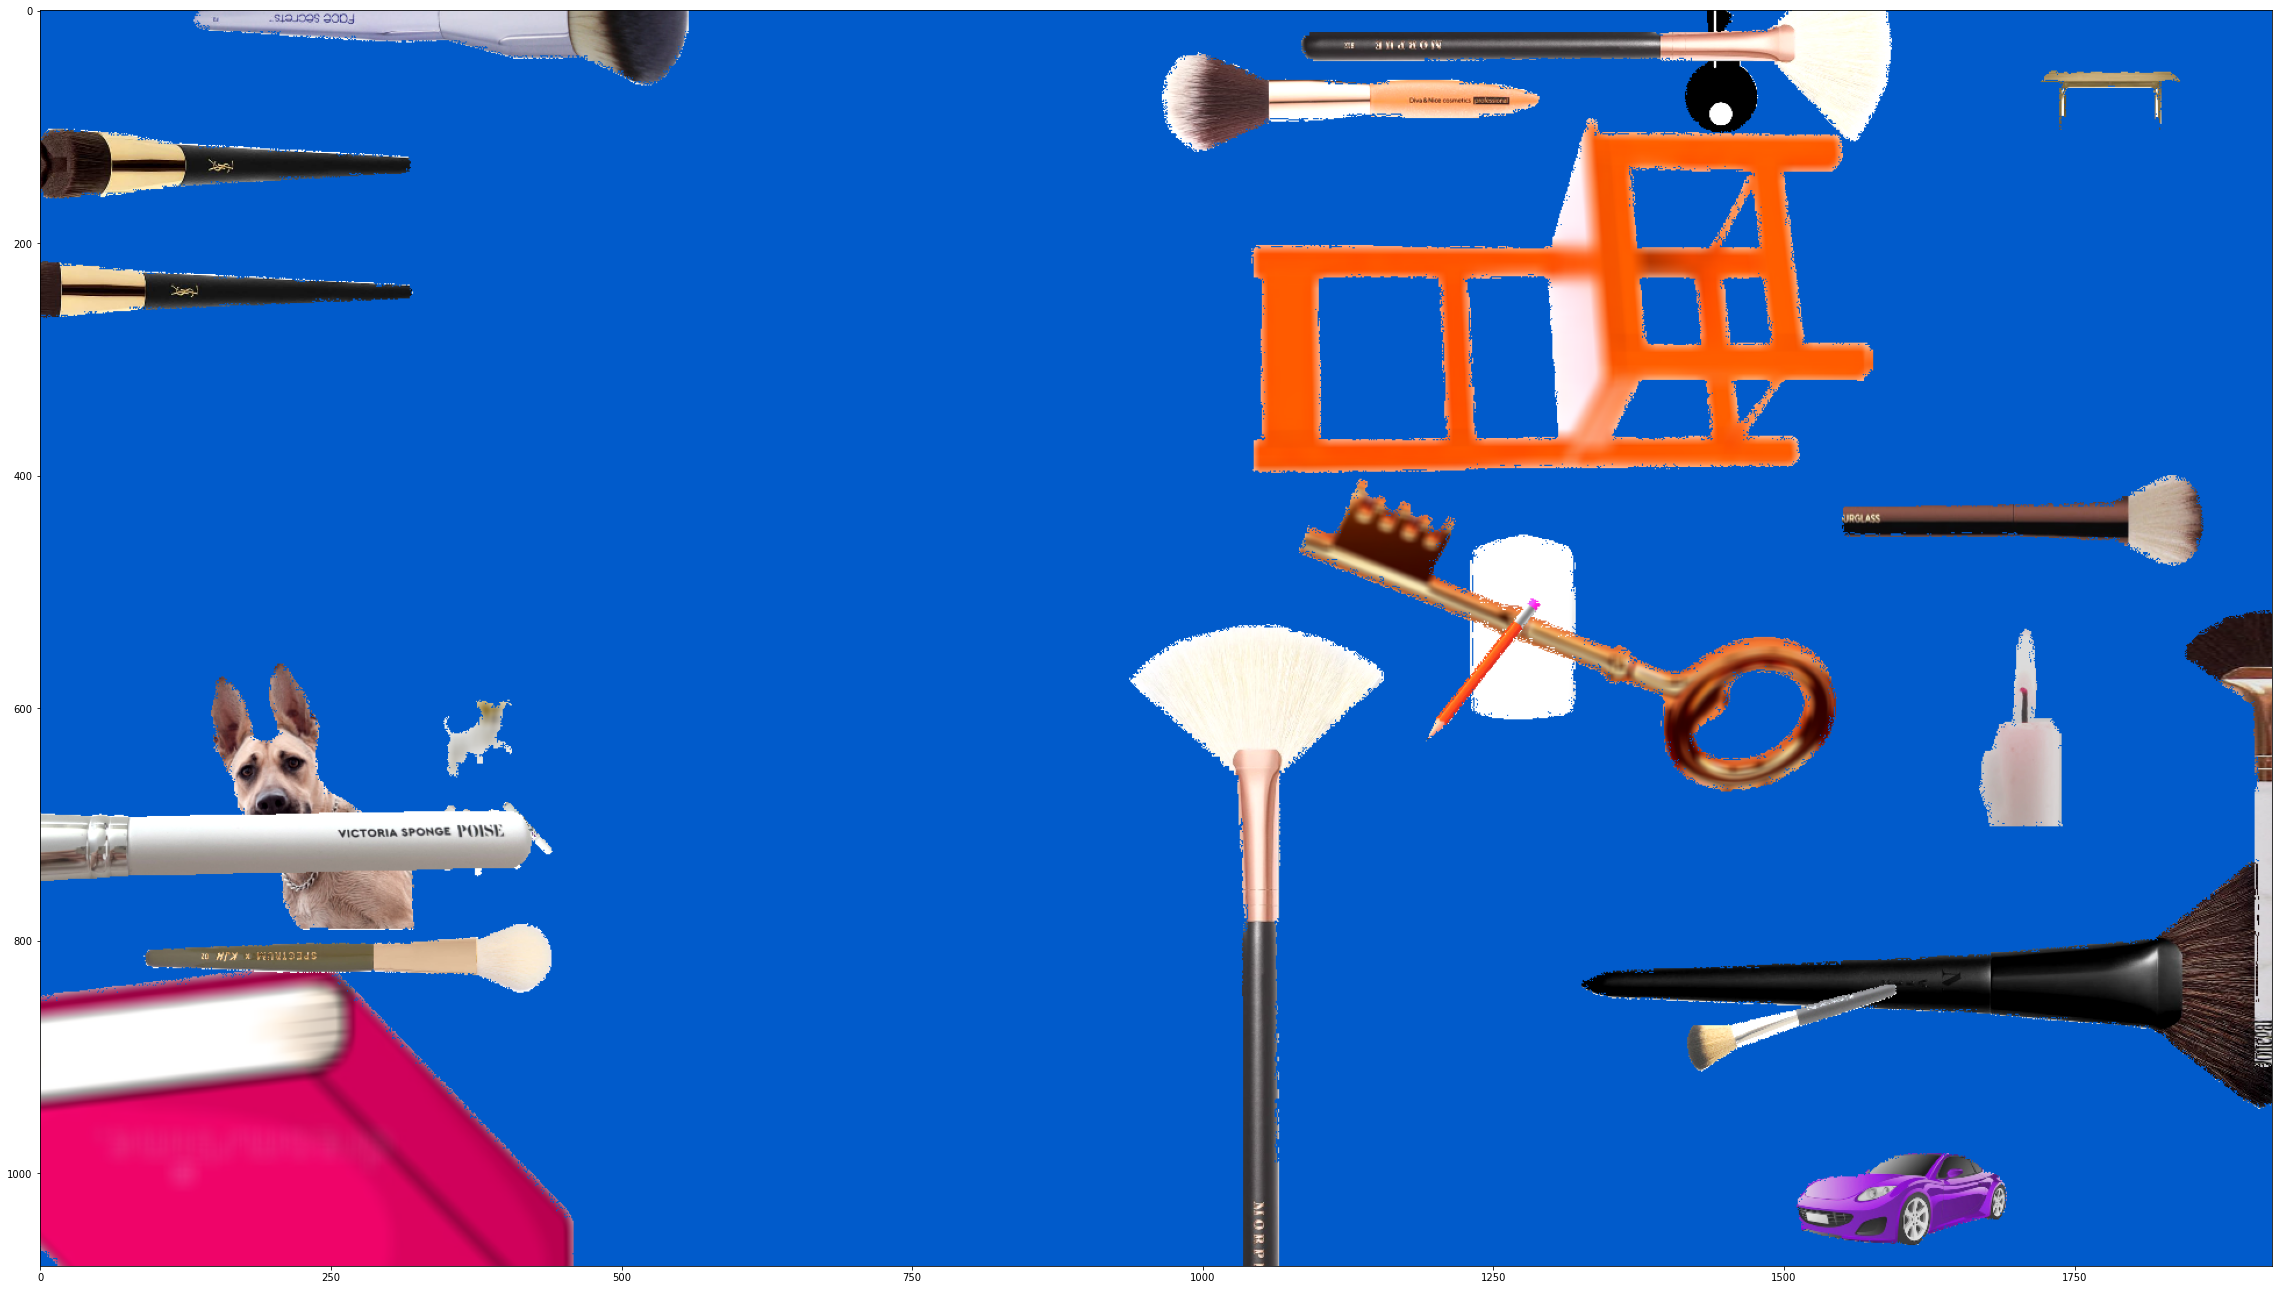

In [23]:
img_comp, mask_comp, labels_comp, obj_areas = create_composition(img_comp_bg,
                                                                 max_objs=15,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)
plt.figure(figsize=(40,40))
plt.imshow(img_comp)

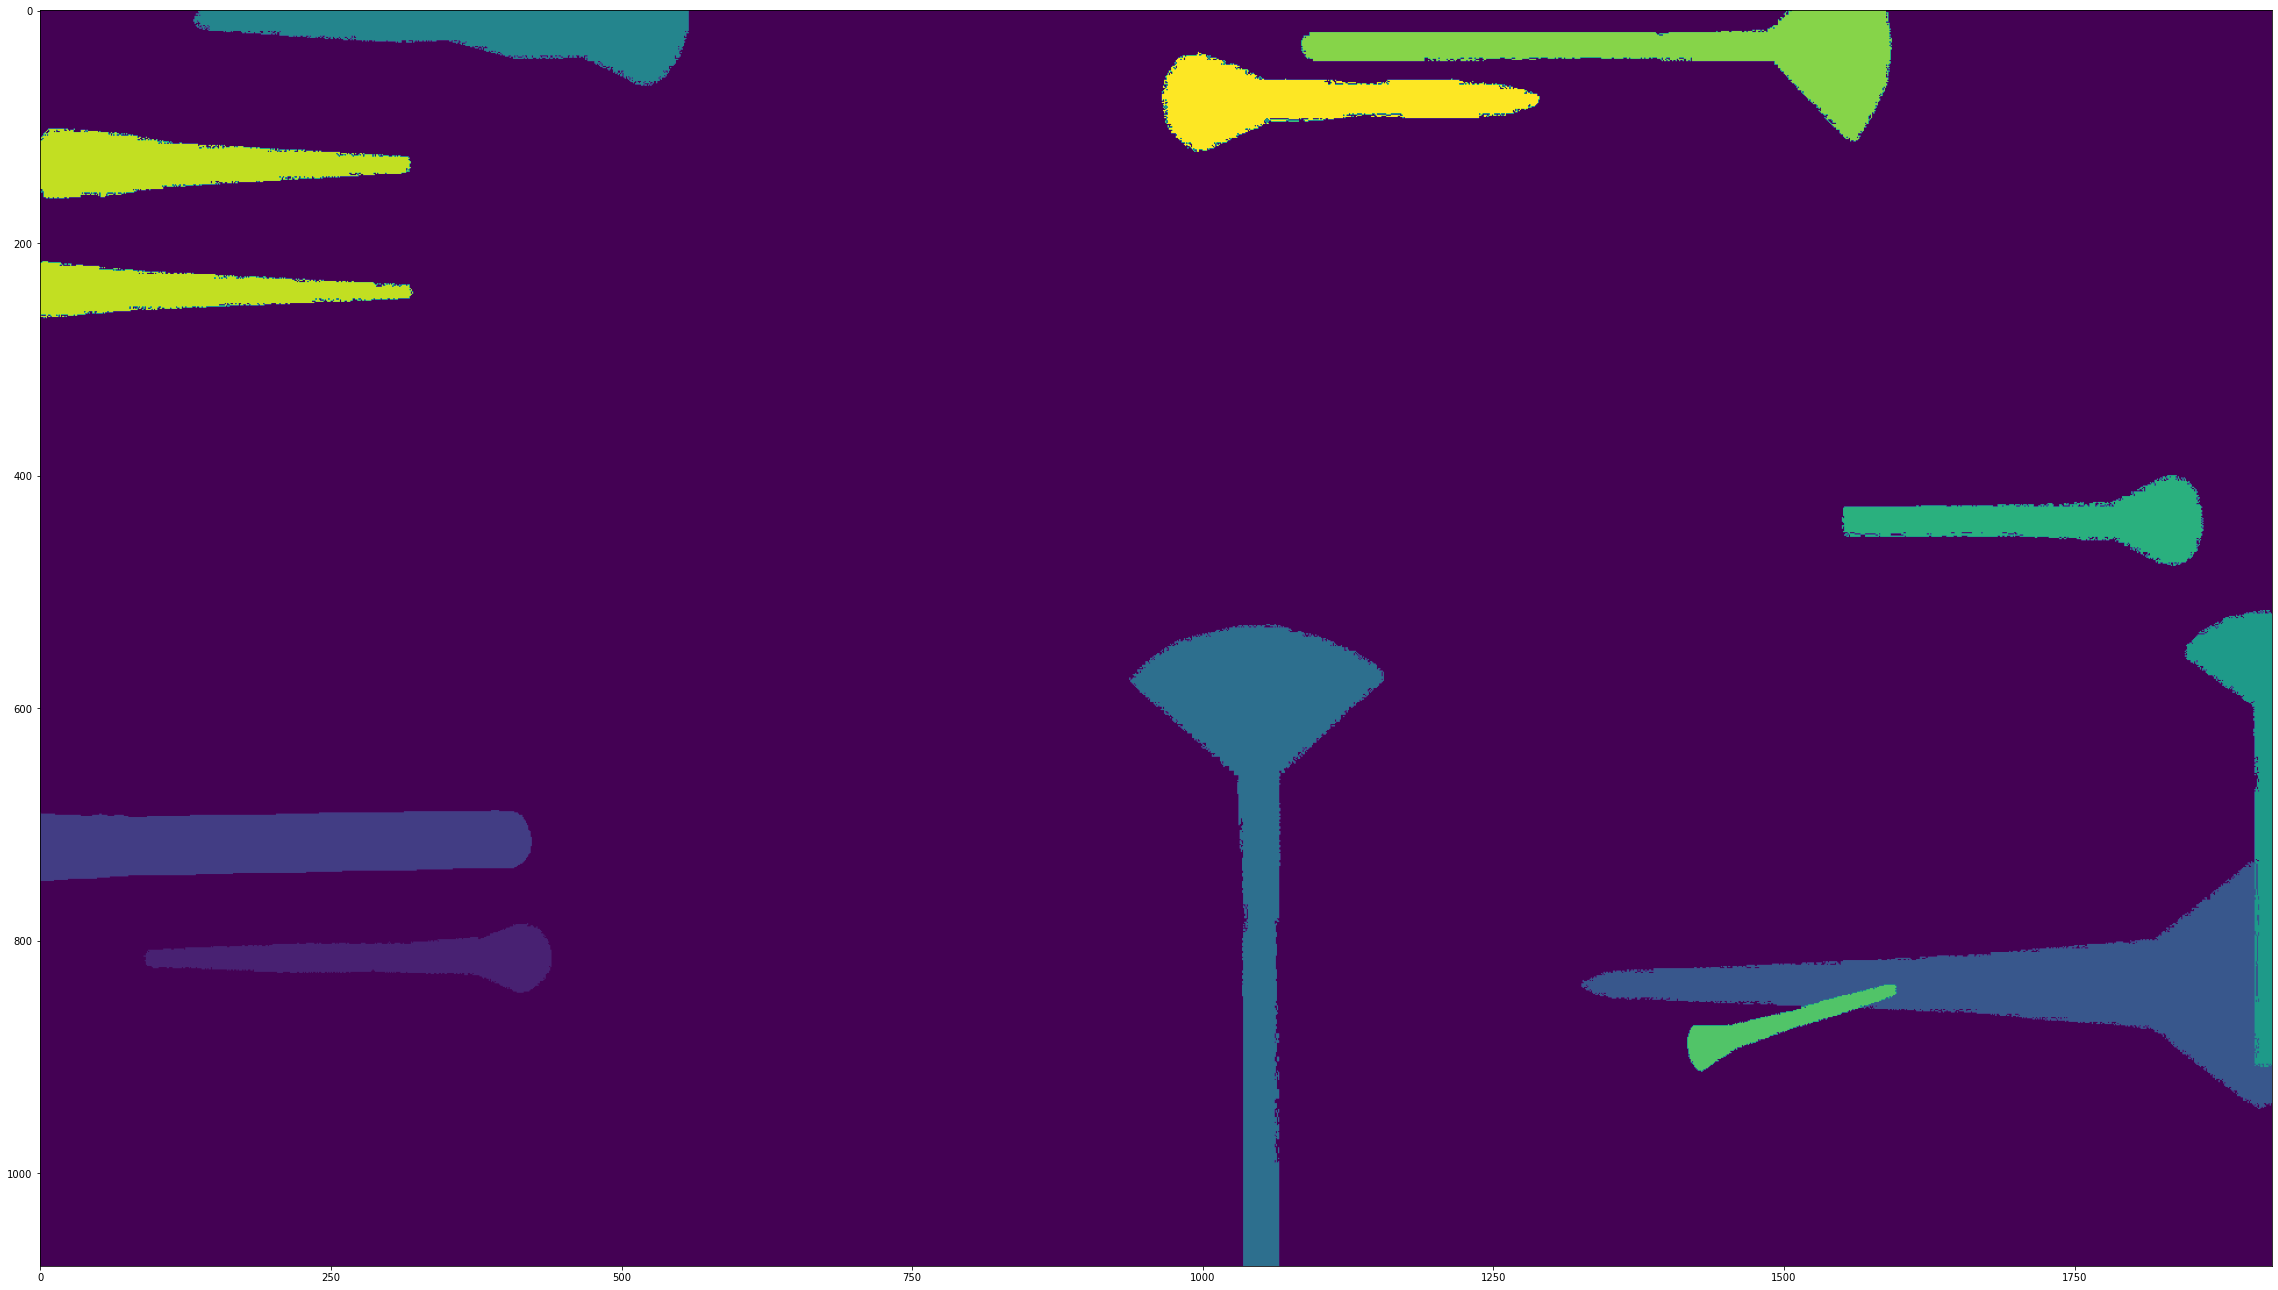

In [24]:
plt.figure(figsize=(40,40))
plt.imshow(mask_comp)

In [25]:
print("Labels (classes of the objects) on the composition in order of object's addition:", labels_comp)

Labels (classes of the objects) on the composition in order of object's addition: [1, 2, 3, 3, 4, 3, 4, 1, 3, 2, 4]


In [26]:
obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

print("Degree of how much area of each object is overlapped:")

for idx, mask in enumerate(masks):
    print(np.count_nonzero(mask) / obj_areas[idx])

Degree of how much area of each object is overlapped:
1.0
1.0
0.9158497841257773
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


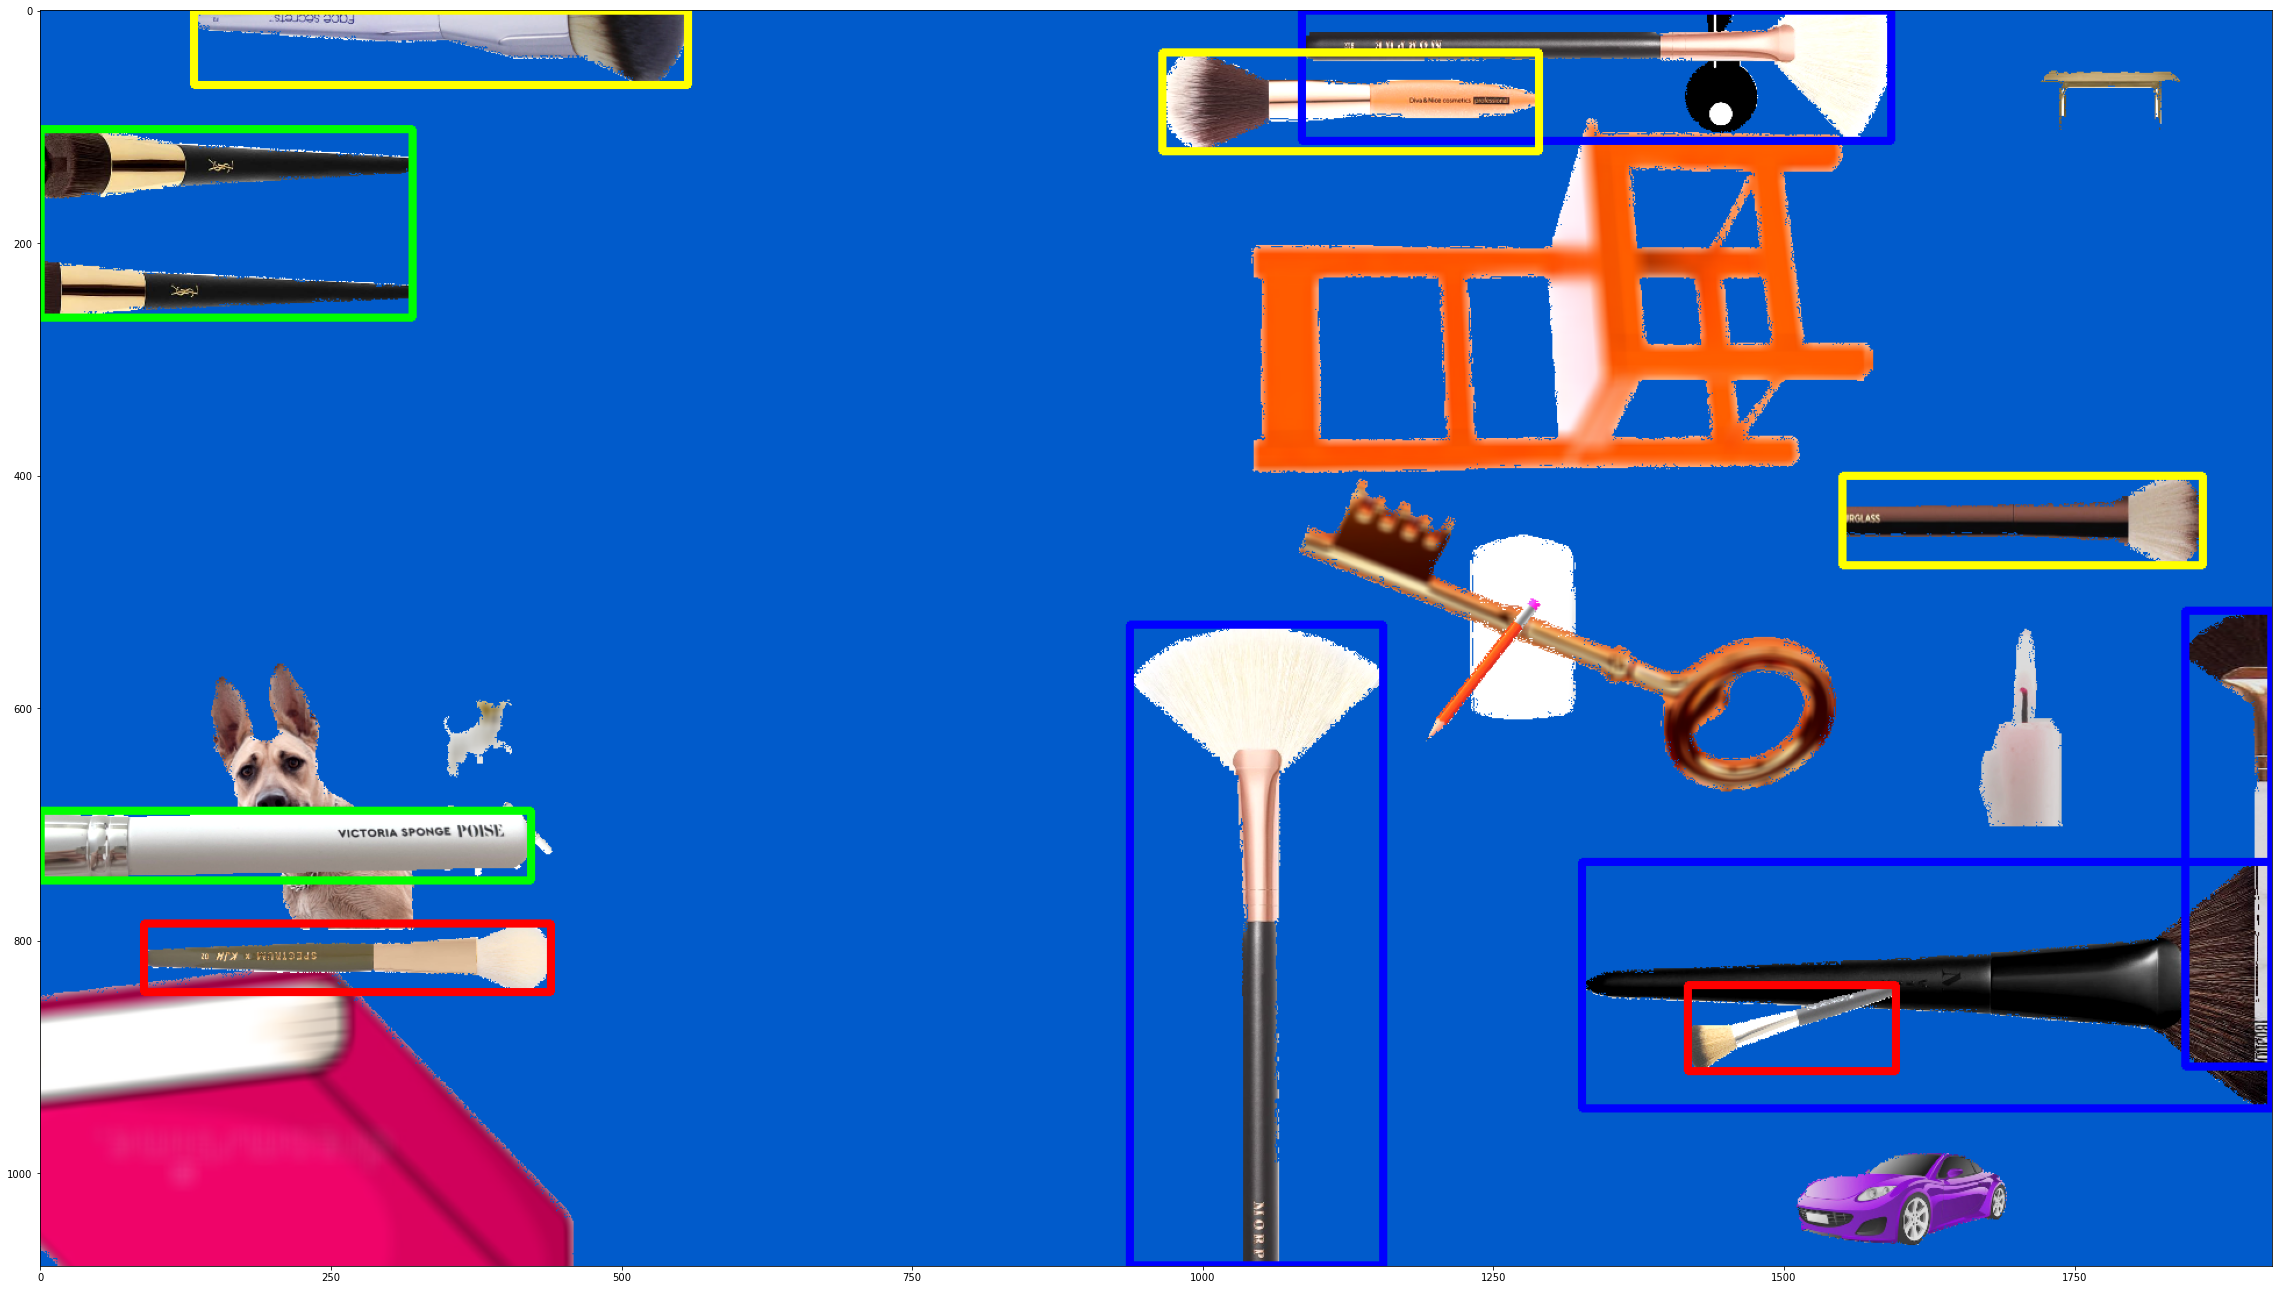

In [27]:
colors = {1: (255,0,0), 2: (0,255,0), 3: (0,0,255), 4: (255,255,0)}

img_comp_bboxes = img_comp.copy()

obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    img_comp_bboxes = cv2.rectangle(img_comp_bboxes,
                                    (xmin, ymin),
                                    (xmax,ymax),
                                    colors[labels_comp[i]],
                                    6)
    
plt.figure(figsize=(40,40))
plt.imshow(img_comp_bboxes)    

In [28]:
# function which creates def create_yolo_annotations(mask_comp, labels_comp):
def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    masks = mask_comp == obj_ids[:, None, None]

    annotations_yolo = []
    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        annotations_yolo.append([labels_comp[i] - 1,
                                 round(xc/comp_w, 5),
                                 round(yc/comp_h, 5),
                                 round(w/comp_w, 5),
                                 round(h/comp_h, 5)])

    return annotations_yolo


In [29]:
# Function returns a list of annotations for each object presented on the mask_comp

annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
for i in range(len(annotations_yolo)):
    print(' '.join(str(el) for el in annotations_yolo[i]))

0 0.1375 0.75417 0.18229 0.05463
1 0.1099 0.66481 0.21979 0.05556
2 0.84505 0.77593 0.30885 0.1963
2 0.54479 0.74398 0.11354 0.51019
3 0.17943 0.02963 0.22135 0.05926
2 0.98021 0.65926 0.03854 0.36296
3 0.88802 0.40602 0.16146 0.0713
0 0.78464 0.81019 0.09323 0.06852
2 0.69714 0.05185 0.26406 0.1037
1 0.08333 0.16944 0.16667 0.15
3 0.58698 0.07269 0.16875 0.0787


In [30]:
# Creating and saving synthetic dataset

def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = create_bg_with_noise(files_bg_imgs,
                                           files_bg_noise_imgs,
                                           files_bg_noise_masks,
                                           max_objs_to_add=60)
        
        img_comp, mask_comp, labels_comp, _ = create_composition(img_comp_bg,
                                                                 max_objs=15,
                                                                 overlap_degree=0.2,
                                                                 max_attempts_per_obj=10)

        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder, split, 'images/{}.jpg').format(j), img_comp)

        annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
        for i in range(len(annotations_yolo)):
            with open(os.path.join(folder, split, 'labels/{}.txt').format(j), "a") as f:
                f.write(' '.join(str(el) for el in annotations_yolo[i]) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'labels')))


In [31]:
# Let’s create dataset of 1000 training images and 200 validating images

generate_dataset(1000, folder='data', split='train')
generate_dataset(200, folder='data', split='valid')

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/98.jpg  ::  dat

  0%|                                          | 1/1000 [00:01<20:09,  1.21s/it]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/10.jp

  0%|                                          | 2/1000 [00:01<12:52,  1.29it/s]

>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/104.jpg  ::  da

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg


  0%|▏                                         | 3/1000 [00:03<17:54,  1.08s/it]

>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg

  0%|▏                                         | 4/1000 [00:04<17:38,  1.06s/it]

>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/77.jpg  :: 

  0%|▏                                         | 5/1000 [00:05<21:15,  1.28s/it]

>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/36.jpg  ::  data/

  1%|▎                                         | 6/1000 [00:06<20:25,  1.23s/it]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/16.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/101.jpg  

  1%|▎                                         | 7/1000 [00:08<23:33,  1.42s/it]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_n

  1%|▎                                         | 8/1000 [00:10<22:27,  1.36s/it]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/8

  1%|▍                                         | 9/1000 [00:11<23:52,  1.45s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images

  1%|▍                                        | 10/1000 [00:13<24:00,  1.46s/it]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/3

  1%|▍                                        | 11/1000 [00:13<20:52,  1.27s/it]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_bru

  1%|▍                                        | 12/1000 [00:14<19:32,  1.19s/it]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg


  1%|▌                                        | 13/1000 [00:15<15:19,  1.07it/s]

>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg


  1%|▌                                        | 14/1000 [00:15<13:19,  1.23it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/84.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_

  2%|▌                                        | 15/1000 [00:17<16:20,  1.00it/s]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/75.jpg  ::  d

  2%|▋                                        | 16/1000 [00:18<15:49,  1.04it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/21.jpg  ::  dat

  2%|▋                                        | 17/1000 [00:18<13:59,  1.17it/s]

>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/imag

  2%|▋                                        | 18/1000 [00:20<16:22,  1.00s/it]

>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/78.jpg 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg


  2%|▊                                        | 19/1000 [00:20<15:50,  1.03it/s]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg


  2%|▊                                        | 20/1000 [00:21<12:08,  1.35it/s]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/73.jpg  :: 

  2%|▊                                        | 21/1000 [00:22<13:21,  1.22it/s]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg


  2%|▉                                        | 22/1000 [00:23<16:57,  1.04s/it]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/59.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg


  2%|▉                                        | 23/1000 [00:25<19:00,  1.17s/it]

>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/105.jpg  ::  data/b

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/

  2%|▉                                        | 24/1000 [00:27<22:35,  1.39s/it]

 ::  data/foundation_brush/masks/6.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg

  2%|█                                        | 25/1000 [00:28<21:13,  1.31s/it]

>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/96.jpg  ::  d

  3%|█                                        | 26/1000 [00:29<22:46,  1.40s/it]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/30.jpg  ::  d

  3%|█                                        | 27/1000 [00:31<23:11,  1.43s/it]

>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/59.jp

  3%|█▏                                       | 28/1000 [00:32<19:30,  1.20s/it]

>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/p

  3%|█▏                                       | 29/1000 [00:32<16:16,  1.01s/it]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_n

  3%|█▏                                       | 30/1000 [00:33<14:05,  1.15it/s]

>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/100.jpg  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/foundation_brush/images/18.jp

  3%|█▎                                       | 31/1000 [00:34<15:18,  1.06it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/79.jpg  ::  dat

  3%|█▎                                       | 32/1000 [00:35<16:00,  1.01it/s]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/22.jpg  ::  data/

  3%|█▎                                       | 33/1000 [00:36<18:13,  1.13s/it]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images

  3%|█▍                                       | 34/1000 [00:37<16:21,  1.02s/it]

>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/45.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/1

  4%|█▍                                       | 35/1000 [00:39<18:43,  1.16s/it]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images

  4%|█▍                                       | 36/1000 [00:39<16:22,  1.02s/it]

>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/6.jpg  ::  data/b

  4%|█▌                                       | 37/1000 [00:41<17:36,  1.10s/it]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/m

  4%|█▌                                       | 38/1000 [00:41<16:21,  1.02s/it]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/11.jpg  ::  dat

  4%|█▌                                       | 39/1000 [00:43<19:08,  1.20s/it]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/93.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg


  4%|█▋                                       | 40/1000 [00:44<19:44,  1.23s/it]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/71.jpg  ::  data/

  4%|█▋                                       | 41/1000 [00:45<18:45,  1.17s/it]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg


  4%|█▋                                       | 42/1000 [00:46<16:50,  1.05s/it]

>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/blush_brush/i

  4%|█▊                                       | 43/1000 [00:47<15:24,  1.03it/s]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/80.jpg  ::  d

  4%|█▊                                       | 44/1000 [00:48<17:50,  1.12s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/74.jpg  ::  dat

  4%|█▊                                       | 45/1000 [00:50<18:58,  1.19s/it]

>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/highlig

  5%|█▉                                       | 46/1000 [00:51<17:53,  1.13s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/60.jpg  ::  data/

  5%|█▉                                       | 47/1000 [00:52<20:34,  1.30s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/72.jpg  ::  data/

  5%|█▉                                       | 48/1000 [00:53<18:30,  1.17s/it]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/19.jpg  ::  dat

  5%|██                                       | 49/1000 [00:54<17:18,  1.09s/it]

>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/im

  5%|██                                       | 50/1000 [00:55<16:12,  1.02s/it]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> da

  5%|██                                       | 51/1000 [00:56<15:11,  1.04it/s]

>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/89.jpg 

  5%|██▏                                      | 52/1000 [00:57<17:35,  1.11s/it]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/18.jpg  ::  data/

  5%|██▏                                      | 53/1000 [00:58<16:12,  1.03s/it]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg


  5%|██▏                                      | 54/1000 [00:59<16:54,  1.07s/it]

>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/imag

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/powder_

  6%|██▎                                      | 55/1000 [01:01<20:19,  1.29s/it]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/8.jpg  ::  data

  6%|██▎                                      | 56/1000 [01:02<18:31,  1.18s/it]

>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/highlighter_brush

  6%|██▎                                      | 57/1000 [01:03<17:30,  1.11s/it]

>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/85.jpg  ::  dat

  6%|██▍                                      | 58/1000 [01:04<18:31,  1.18s/it]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/7.jpg  ::  data

  6%|██▍                                      | 59/1000 [01:05<16:47,  1.07s/it]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/pow

  6%|██▍                                      | 60/1000 [01:06<15:33,  1.01it/s]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/105.jpg  ::  

  6%|██▌                                      | 61/1000 [01:07<15:38,  1.00it/s]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/37.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg


  6%|██▌                                      | 62/1000 [01:08<17:52,  1.14s/it]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/101.jpg  ::  da

  6%|██▌                                      | 63/1000 [01:09<14:52,  1.05it/s]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg


  6%|██▌                                      | 64/1000 [01:09<11:36,  1.34it/s]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>

  6%|██▋                                      | 65/1000 [01:10<11:42,  1.33it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_

  7%|██▋                                      | 66/1000 [01:11<12:32,  1.24it/s]

>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg


  7%|██▋                                      | 67/1000 [01:11<10:37,  1.46it/s]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/

  7%|██▊                                      | 68/1000 [01:12<09:18,  1.67it/s]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/

  7%|██▊                                      | 69/1000 [01:14<15:31,  1.00s/it]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg


  7%|██▊                                      | 70/1000 [01:14<12:34,  1.23it/s]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> da

  7%|██▉                                      | 71/1000 [01:15<12:25,  1.25it/s]

>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/45.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg


  7%|██▉                                      | 72/1000 [01:16<13:17,  1.16it/s]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> 

  7%|██▉                                      | 73/1000 [01:17<13:11,  1.17it/s]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/57.jpg  ::  dat

  7%|███                                      | 74/1000 [01:18<14:38,  1.05it/s]

>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/9.jpg  ::  data/b

  8%|███                                      | 75/1000 [01:19<16:13,  1.05s/it]

>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/78.

  8%|███                                      | 76/1000 [01:20<17:25,  1.13s/it]

>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/mask

  8%|███▏                                     | 77/1000 [01:21<16:29,  1.07s/it]

>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/55.jpg  ::  d

  8%|███▏                                     | 78/1000 [01:23<17:17,  1.13s/it]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/39.jpg  ::  dat

  8%|███▏                                     | 79/1000 [01:23<15:59,  1.04s/it]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/70.jpg  ::  data/

  8%|███▎                                     | 80/1000 [01:25<18:37,  1.21s/it]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/69.jpg  ::  dat

  8%|███▎                                     | 81/1000 [01:27<19:56,  1.30s/it]

>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/4.j

  8%|███▎                                     | 82/1000 [01:28<19:10,  1.25s/it]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blu

  8%|███▍                                     | 83/1000 [01:28<15:35,  1.02s/it]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/95.jpg  ::  d

  8%|███▍                                     | 84/1000 [01:30<17:34,  1.15s/it]

>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/14.jpg  ::  d

  8%|███▍                                     | 85/1000 [01:30<15:24,  1.01s/it]

>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/33.jpg  ::  dat

  9%|███▌                                     | 86/1000 [01:31<15:25,  1.01s/it]

>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images

  9%|███▌                                     | 87/1000 [01:33<17:35,  1.16s/it]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.

  9%|███▌                                     | 88/1000 [01:34<17:03,  1.12s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/26.jpg  ::  d

  9%|███▋                                     | 89/1000 [01:35<17:21,  1.14s/it]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/26.jpg  ::  dat

  9%|███▋                                     | 90/1000 [01:36<17:46,  1.17s/it]

>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/17.jpg  :: 

  9%|███▋                                     | 91/1000 [01:37<15:27,  1.02s/it]

>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/highlighter_brush/images/13

  9%|███▊                                     | 92/1000 [01:37<13:12,  1.15it/s]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/mask

  9%|███▊                                     | 93/1000 [01:38<13:33,  1.12it/s]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg


  9%|███▊                                     | 94/1000 [01:39<12:26,  1.21it/s]

>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> da

 10%|███▉                                     | 95/1000 [01:40<12:25,  1.21it/s]

>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/41.

 10%|███▉                                     | 96/1000 [01:41<15:06,  1.00s/it]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/93.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg


 10%|███▉                                     | 97/1000 [01:42<13:43,  1.10it/s]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/21.jpg  ::  dat

 10%|████                                     | 98/1000 [01:43<14:53,  1.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/1.jpg  ::  data

 10%|████                                     | 99/1000 [01:44<15:12,  1.01s/it]

>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_n

 10%|████                                    | 100/1000 [01:46<18:18,  1.22s/it]

>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.

 10%|████                                    | 101/1000 [01:47<15:36,  1.04s/it]

>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/66.jpg  :

 10%|████                                    | 102/1000 [01:48<16:30,  1.10s/it]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/

 10%|████                                    | 103/1000 [01:49<15:49,  1.06s/it]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/50.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/powde

 10%|████▏                                   | 104/1000 [01:50<17:44,  1.19s/it]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data

 10%|████▏                                   | 105/1000 [01:51<17:11,  1.15s/it]

>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/101.jpg  ::  data/b

 11%|████▏                                   | 106/1000 [01:52<15:46,  1.06s/it]

>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/34.jpg  ::  dat

 11%|████▎                                   | 107/1000 [01:53<14:55,  1.00s/it]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg


 11%|████▎                                   | 108/1000 [01:53<12:07,  1.23it/s]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg


 11%|████▎                                   | 109/1000 [01:55<14:30,  1.02it/s]

>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg

 11%|████▍                                   | 110/1000 [01:56<14:29,  1.02it/s]

>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/82.jpg  ::  data/

 11%|████▍                                   | 111/1000 [01:57<16:07,  1.09s/it]

>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush

 11%|████▍                                   | 112/1000 [01:58<15:05,  1.02s/it]

>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg


 11%|████▌                                   | 113/1000 [01:58<11:49,  1.25it/s]

>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/24.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 11%|████▌                                   | 114/1000 [01:59<11:26,  1.29it/s]

>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_

 12%|████▌                                   | 115/1000 [02:00<13:48,  1.07it/s]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/41.jpg  ::  d

 12%|████▋                                   | 116/1000 [02:01<13:58,  1.05it/s]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/63.jpg  ::  data/

 12%|████▋                                   | 117/1000 [02:02<12:12,  1.21it/s]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_

 12%|████▋                                   | 118/1000 [02:02<11:15,  1.31it/s]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/60.jpg  ::  d

 12%|████▊                                   | 119/1000 [02:04<15:30,  1.06s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/84.jpg  ::  dat

 12%|████▊                                   | 120/1000 [02:06<17:29,  1.19s/it]

>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlig

 12%|████▊                                   | 121/1000 [02:07<16:50,  1.15s/it]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/28.jpg  ::  d

 12%|████▉                                   | 122/1000 [02:08<17:18,  1.18s/it]

>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/foundation_brush/images/1

 12%|████▉                                   | 123/1000 [02:09<15:52,  1.09s/it]

>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/highlighter_brush/images/

 12%|████▉                                   | 124/1000 [02:10<16:44,  1.15s/it]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png


 12%|█████                                   | 125/1000 [02:11<14:06,  1.03it/s]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/44.jpg  :: 

 13%|█████                                   | 126/1000 [02:12<14:17,  1.02it/s]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/im

 13%|█████                                   | 127/1000 [02:13<14:11,  1.03it/s]

>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg


 13%|█████                                   | 128/1000 [02:14<14:06,  1.03it/s]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/63.jpg  ::  data/

 13%|█████▏                                  | 129/1000 [02:15<15:29,  1.07s/it]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images

 13%|█████▏                                  | 130/1000 [02:16<16:43,  1.15s/it]

>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/19.jpg  :

 13%|█████▏                                  | 131/1000 [02:17<15:09,  1.05s/it]

>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/29.jpg  ::  data/

 13%|█████▎                                  | 132/1000 [02:18<15:02,  1.04s/it]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/17.jpg  :

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg


 13%|█████▎                                  | 133/1000 [02:19<14:02,  1.03it/s]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/4

 13%|█████▎                                  | 134/1000 [02:20<14:49,  1.03s/it]

>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/2

 14%|█████▍                                  | 135/1000 [02:21<13:21,  1.08it/s]

>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_nois

 14%|█████▍                                  | 136/1000 [02:22<15:46,  1.10s/it]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg


 14%|█████▍                                  | 137/1000 [02:23<14:30,  1.01s/it]

>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/90.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg


 14%|█████▌                                  | 138/1000 [02:24<14:19,  1.00it/s]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/17.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 14%|█████▌                                  | 139/1000 [02:25<14:34,  1.02s/it]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/imag

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg


 14%|█████▌                                  | 140/1000 [02:26<13:08,  1.09it/s]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images

 14%|█████▋                                  | 141/1000 [02:27<14:48,  1.03s/it]

>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_

 14%|█████▋                                  | 142/1000 [02:28<13:42,  1.04it/s]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/7

 14%|█████▋                                  | 143/1000 [02:29<13:38,  1.05it/s]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/2

 14%|█████▊                                  | 144/1000 [02:29<11:07,  1.28it/s]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/

 14%|█████▊                                  | 145/1000 [02:30<11:53,  1.20it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/65.jpg  ::  data/

 15%|█████▊                                  | 146/1000 [02:31<13:58,  1.02it/s]

>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/77.jpg 

 15%|█████▉                                  | 147/1000 [02:32<13:29,  1.05it/s]

>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/6

 15%|█████▉                                  | 148/1000 [02:33<11:52,  1.20it/s]

>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/70.jpg  :

 15%|█████▉                                  | 149/1000 [02:34<11:57,  1.19it/s]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/mas

 15%|██████                                  | 150/1000 [02:34<10:40,  1.33it/s]

>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/25.jpg  ::  data/

 15%|██████                                  | 151/1000 [02:35<10:25,  1.36it/s]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg


 15%|██████                                  | 152/1000 [02:35<09:00,  1.57it/s]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/2

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/mas

 15%|██████                                  | 153/1000 [02:37<11:50,  1.19it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/5

 15%|██████▏                                 | 154/1000 [02:38<13:04,  1.08it/s]

>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/2

 16%|██████▏                                 | 156/1000 [02:39<09:51,  1.43it/s]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/mas

 16%|██████▎                                 | 157/1000 [02:40<09:00,  1.56it/s]

>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/65.jpg  :: 

 16%|██████▎                                 | 158/1000 [02:41<12:24,  1.13it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/62.jpg  ::  dat

 16%|██████▎                                 | 159/1000 [02:42<11:55,  1.18it/s]

>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/37.jpg 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg


 16%|██████▍                                 | 160/1000 [02:43<13:16,  1.05it/s]

>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/imag

 16%|██████▍                                 | 161/1000 [02:44<12:21,  1.13it/s]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/2

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg


 16%|██████▍                                 | 162/1000 [02:45<15:09,  1.08s/it]

>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/104.jpg  

 16%|██████▌                                 | 163/1000 [02:46<13:58,  1.00s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/foundation_brush/images/17.jpg 

 16%|██████▌                                 | 164/1000 [02:47<15:11,  1.09s/it]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/89.jpg  ::  data/

 16%|██████▌                                 | 165/1000 [02:49<17:27,  1.25s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/pow

 17%|██████▋                                 | 166/1000 [02:50<15:40,  1.13s/it]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg


 17%|██████▋                                 | 167/1000 [02:50<12:01,  1.15it/s]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/26.jpg  ::  d

 17%|██████▋                                 | 168/1000 [02:52<14:59,  1.08s/it]

>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/102.jpg  ::  

 17%|██████▊                                 | 169/1000 [02:53<15:08,  1.09s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_bru

 17%|██████▊                                 | 170/1000 [02:54<16:09,  1.17s/it]

>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg


 17%|██████▊                                 | 171/1000 [02:54<13:02,  1.06it/s]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/72.jpg  :

 17%|██████▉                                 | 172/1000 [02:55<11:48,  1.17it/s]

>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_nois

 17%|██████▉                                 | 173/1000 [02:56<12:31,  1.10it/s]

>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/102.jpg  ::  da

 17%|██████▉                                 | 174/1000 [02:57<11:36,  1.19it/s]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/4

 18%|███████                                 | 175/1000 [02:58<12:34,  1.09it/s]

>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images

 18%|███████                                 | 176/1000 [02:59<12:56,  1.06it/s]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/found

 18%|███████                                 | 177/1000 [03:00<14:08,  1.03s/it]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/35.jpg  ::  dat

 18%|███████                                 | 178/1000 [03:02<15:58,  1.17s/it]

>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/47.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg


 18%|███████▏                                | 179/1000 [03:03<15:28,  1.13s/it]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/

 18%|███████▏                                | 180/1000 [03:04<16:29,  1.21s/it]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg


 18%|███████▏                                | 181/1000 [03:04<12:54,  1.06it/s]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images

 18%|███████▎                                | 182/1000 [03:05<12:13,  1.12it/s]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/92.jpg  ::  dat

 18%|███████▎                                | 183/1000 [03:06<12:10,  1.12it/s]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/67.jpg  ::  data/

 18%|███████▎                                | 184/1000 [03:08<15:43,  1.16s/it]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/37.jpg  ::  data/

 18%|███████▍                                | 185/1000 [03:08<13:26,  1.01it/s]

>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/b

 19%|███████▍                                | 186/1000 [03:09<13:11,  1.03it/s]

>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/90.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/5.jpg  ::  da

 19%|███████▍                                | 187/1000 [03:11<14:37,  1.08s/it]

>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/53.jpg  ::  data/

 19%|███████▌                                | 188/1000 [03:12<16:22,  1.21s/it]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg


 19%|███████▌                                | 189/1000 [03:14<16:41,  1.23s/it]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/

 19%|███████▌                                | 190/1000 [03:14<13:58,  1.03s/it]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_

 19%|███████▋                                | 191/1000 [03:15<12:44,  1.06it/s]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/foundation_brush/images/20.jpg  :

 19%|███████▋                                | 192/1000 [03:15<11:13,  1.20it/s]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images

 19%|███████▋                                | 193/1000 [03:17<13:23,  1.00it/s]

>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/45.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> da

 19%|███████▊                                | 194/1000 [03:19<16:30,  1.23s/it]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/18.jpg  ::  d

 20%|███████▊                                | 195/1000 [03:20<16:54,  1.26s/it]

>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/

 20%|███████▊                                | 196/1000 [03:21<17:47,  1.33s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/30.jpg  ::  data/

 20%|███████▉                                | 197/1000 [03:23<18:15,  1.36s/it]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg


 20%|███████▉                                | 198/1000 [03:23<13:17,  1.01it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/91.jpg  ::  data/

 20%|███████▉                                | 199/1000 [03:24<14:40,  1.10s/it]

>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/powder_brush/images/1

 20%|████████                                | 200/1000 [03:26<15:47,  1.18s/it]

>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/34.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/foundation_brush/images/16.jpg  :

 20%|████████                                | 201/1000 [03:27<14:45,  1.11s/it]

>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blu

 20%|████████                                | 202/1000 [03:27<13:39,  1.03s/it]

>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/27.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 20%|████████                                | 203/1000 [03:28<13:27,  1.01s/it]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/86.jpg  ::  d

 20%|████████▏                               | 204/1000 [03:29<13:12,  1.00it/s]

>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush

 20%|████████▏                               | 205/1000 [03:31<13:39,  1.03s/it]

>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/90.jpg  ::  dat

 21%|████████▏                               | 206/1000 [03:32<13:30,  1.02s/it]

>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> da

 21%|████████▎                               | 207/1000 [03:32<11:51,  1.11it/s]

>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg

 21%|████████▎                               | 208/1000 [03:33<10:32,  1.25it/s]

>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg

 21%|████████▎                               | 209/1000 [03:34<11:27,  1.15it/s]

>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/28.jpg  :: 

 21%|████████▍                               | 210/1000 [03:36<15:53,  1.21s/it]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/58.jpg  ::  dat

 21%|████████▍                               | 211/1000 [03:37<15:15,  1.16s/it]

>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/28.jpg 

 21%|████████▍                               | 212/1000 [03:37<12:18,  1.07it/s]

>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_no

 21%|████████▌                               | 213/1000 [03:38<11:16,  1.16it/s]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> da

 21%|████████▌                               | 214/1000 [03:39<12:43,  1.03it/s]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/21.jpg  :: 

 22%|████████▌                               | 215/1000 [03:40<11:30,  1.14it/s]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/37.jpg  :: 

 22%|████████▋                               | 216/1000 [03:41<13:36,  1.04s/it]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/50.jpg  ::  dat

 22%|████████▋                               | 217/1000 [03:42<12:23,  1.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/71.jpg  ::  data/

 22%|████████▋                               | 218/1000 [03:42<10:49,  1.20it/s]

>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/blu

 22%|████████▊                               | 219/1000 [03:43<11:32,  1.13it/s]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/blush_bru

 22%|████████▊                               | 220/1000 [03:44<11:20,  1.15it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg


 22%|████████▊                               | 221/1000 [03:45<08:51,  1.47it/s]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_bru

 22%|████████▉                               | 222/1000 [03:45<09:40,  1.34it/s]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_no

 22%|████████▉                               | 223/1000 [03:47<13:05,  1.01s/it]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/9.jpg  ::  d

 22%|████████▉                               | 224/1000 [03:48<11:10,  1.16it/s]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/13.jpg  ::  d

 22%|█████████                               | 225/1000 [03:48<10:49,  1.19it/s]

>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg

 23%|█████████                               | 226/1000 [03:49<10:07,  1.27it/s]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg


 23%|█████████                               | 227/1000 [03:49<08:30,  1.51it/s]

>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/79.

 23%|█████████                               | 228/1000 [03:51<10:26,  1.23it/s]

>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg


 23%|█████████▏                              | 229/1000 [03:51<08:26,  1.52it/s]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg

 23%|█████████▏                              | 230/1000 [03:52<09:50,  1.30it/s]

>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images

 23%|█████████▏                              | 231/1000 [03:53<10:20,  1.24it/s]

>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/4

 23%|█████████▎                              | 232/1000 [03:54<12:47,  1.00it/s]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/blush_brush/images/22.jpg  ::  

 23%|█████████▎                              | 233/1000 [03:55<11:32,  1.11it/s]

>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/34.jpg  ::  d

 23%|█████████▎                              | 234/1000 [03:57<14:43,  1.15s/it]

>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg


 24%|█████████▍                              | 235/1000 [03:57<12:36,  1.01it/s]

>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg


 24%|█████████▍                              | 236/1000 [03:57<09:38,  1.32it/s]

>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/5

 24%|█████████▍                              | 237/1000 [03:59<12:04,  1.05it/s]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlight

 24%|█████████▌                              | 238/1000 [04:00<11:40,  1.09it/s]

>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/1.jpg  ::  data

 24%|█████████▌                              | 239/1000 [04:01<14:37,  1.15s/it]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/72.jpg  ::  dat

 24%|█████████▌                              | 240/1000 [04:02<14:09,  1.12s/it]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg

 24%|█████████▋                              | 241/1000 [04:04<13:57,  1.10s/it]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/mask

 24%|█████████▋                              | 242/1000 [04:04<12:00,  1.05it/s]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg


 24%|█████████▋                              | 243/1000 [04:05<10:10,  1.24it/s]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/66.

 24%|█████████▊                              | 244/1000 [04:05<10:27,  1.20it/s]

>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/28.jpg  :

 24%|█████████▊                              | 245/1000 [04:07<12:55,  1.03s/it]

>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/35.jpg  ::  dat

 25%|█████████▊                              | 246/1000 [04:08<13:35,  1.08s/it]

>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images

 25%|█████████▉                              | 247/1000 [04:09<11:43,  1.07it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/12.jp

 25%|█████████▉                              | 248/1000 [04:10<12:06,  1.03it/s]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_b

 25%|█████████▉                              | 249/1000 [04:11<12:12,  1.03it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/40.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/49.jpg  :

 25%|██████████                              | 250/1000 [04:12<14:39,  1.17s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg


 25%|██████████                              | 251/1000 [04:13<11:18,  1.10it/s]

>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/83.jpg  ::  d

 25%|██████████                              | 252/1000 [04:14<12:36,  1.01s/it]

>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/13.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/69.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg


 25%|██████████                              | 253/1000 [04:15<13:18,  1.07s/it]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/20.jpg  ::  d

 25%|██████████▏                             | 254/1000 [04:16<12:15,  1.01it/s]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jp

 26%|██████████▏                             | 255/1000 [04:17<11:47,  1.05it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/29.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg


 26%|██████████▏                             | 256/1000 [04:18<12:21,  1.00it/s]

>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noi

 26%|██████████▎                             | 257/1000 [04:18<10:31,  1.18it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/34.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg


 26%|██████████▎                             | 258/1000 [04:19<10:05,  1.22it/s]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/98.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/59.jpg  ::  data/

 26%|██████████▎                             | 259/1000 [04:20<10:35,  1.17it/s]

>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/imag

 26%|██████████▍                             | 260/1000 [04:21<10:56,  1.13it/s]

>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/

 26%|██████████▍                             | 261/1000 [04:22<11:08,  1.11it/s]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/

 26%|██████████▍                             | 262/1000 [04:23<09:56,  1.24it/s]

>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/5.jpg  ::

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg


 26%|██████████▌                             | 263/1000 [04:24<10:21,  1.19it/s]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 26%|██████████▌                             | 264/1000 [04:24<10:11,  1.20it/s]

>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_nois

 26%|██████████▌                             | 265/1000 [04:25<09:41,  1.26it/s]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/105.jpg  ::

 27%|██████████▋                             | 266/1000 [04:27<13:06,  1.07s/it]

>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/founda

 27%|██████████▋                             | 267/1000 [04:28<13:06,  1.07s/it]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_brush/images/1.jpg  ::  

 27%|██████████▋                             | 268/1000 [04:29<12:20,  1.01s/it]

>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/mas

 27%|██████████▊                             | 269/1000 [04:30<12:36,  1.04s/it]

>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/28.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highli

 27%|██████████▊                             | 270/1000 [04:31<13:28,  1.11s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/70.jp

 27%|██████████▊                             | 271/1000 [04:32<13:24,  1.10s/it]

>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/9.jpg  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg


 27%|██████████▉                             | 272/1000 [04:33<12:59,  1.07s/it]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/23.jpg  ::  d

 27%|██████████▉                             | 273/1000 [04:35<15:08,  1.25s/it]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jp

 27%|██████████▉                             | 274/1000 [04:35<11:51,  1.02it/s]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/imag

 28%|███████████                             | 275/1000 [04:36<11:16,  1.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/33.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 28%|███████████                             | 276/1000 [04:37<10:45,  1.12it/s]

>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg


 28%|███████████                             | 277/1000 [04:37<09:42,  1.24it/s]

>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/4

 28%|███████████                             | 278/1000 [04:39<10:42,  1.12it/s]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/10.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 28%|███████████▏                            | 279/1000 [04:40<12:08,  1.01s/it]

>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg


 28%|███████████▏                            | 280/1000 [04:41<13:39,  1.14s/it]

>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/6.jpg  ::  da

 28%|███████████▏                            | 281/1000 [04:42<12:44,  1.06s/it]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_no

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data

 28%|███████████▎                            | 282/1000 [04:43<13:12,  1.10s/it]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/25.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg


 28%|███████████▎                            | 283/1000 [04:44<11:52,  1.01it/s]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/47.jpg  ::  data/

 28%|███████████▎                            | 284/1000 [04:46<14:37,  1.23s/it]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/96.jpg 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/52.jpg  ::  d

 28%|███████████▍                            | 285/1000 [04:47<16:00,  1.34s/it]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg


 29%|███████████▍                            | 286/1000 [04:48<13:01,  1.09s/it]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/29.jpg  ::  d

 29%|███████████▍                            | 287/1000 [04:50<14:54,  1.25s/it]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/p

 29%|███████████▌                            | 288/1000 [04:50<12:35,  1.06s/it]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/21.jpg 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg


 29%|███████████▌                            | 289/1000 [04:51<12:29,  1.05s/it]

>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/11.jpg  

 29%|███████████▌                            | 290/1000 [04:52<10:54,  1.09it/s]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/im

 29%|███████████▋                            | 291/1000 [04:53<12:22,  1.05s/it]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/20.jp

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg


 29%|███████████▋                            | 292/1000 [04:54<11:55,  1.01s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg


 29%|███████████▋                            | 293/1000 [04:55<12:37,  1.07s/it]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/75.jpg  :: 

 30%|███████████▊                            | 295/1000 [04:56<09:02,  1.30it/s]

>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg


 30%|███████████▊                            | 296/1000 [04:57<07:42,  1.52it/s]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_no

 30%|███████████▉                            | 297/1000 [04:58<10:39,  1.10it/s]

>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/17.jpg  :

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg


 30%|███████████▉                            | 298/1000 [05:00<13:10,  1.13s/it]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg


 30%|███████████▉                            | 299/1000 [05:00<10:28,  1.11it/s]

>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images

 30%|████████████                            | 300/1000 [05:02<13:32,  1.16s/it]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg

 30%|████████████                            | 301/1000 [05:03<14:15,  1.22s/it]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/35.jpg  ::  dat

 30%|████████████                            | 302/1000 [05:05<14:52,  1.28s/it]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/8.jpg  ::  data

 30%|████████████                            | 303/1000 [05:06<15:03,  1.30s/it]

>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/77.

 30%|████████████▏                           | 304/1000 [05:07<13:03,  1.13s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg

 30%|████████████▏                           | 305/1000 [05:08<11:28,  1.01it/s]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg


 31%|████████████▏                           | 306/1000 [05:08<10:39,  1.08it/s]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/24.jpg  ::  data/

 31%|████████████▎                           | 307/1000 [05:10<11:26,  1.01it/s]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/33.jpg  ::  d

 31%|████████████▎                           | 308/1000 [05:11<12:42,  1.10s/it]

>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/81.jpg  ::  data/

 31%|████████████▎                           | 309/1000 [05:12<11:14,  1.02it/s]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_n

 31%|████████████▍                           | 310/1000 [05:12<10:50,  1.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>

 31%|████████████▍                           | 311/1000 [05:14<11:44,  1.02s/it]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/2.jpg  ::  data

 31%|████████████▍                           | 312/1000 [05:15<12:16,  1.07s/it]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/70.jpg  ::  data/

 31%|████████████▌                           | 313/1000 [05:16<12:55,  1.13s/it]

>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/60.jpg  ::  dat

 31%|████████████▌                           | 314/1000 [05:17<12:49,  1.12s/it]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/64.jpg  ::  dat

 32%|████████████▌                           | 315/1000 [05:18<12:27,  1.09s/it]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation

 32%|████████████▋                           | 316/1000 [05:19<11:36,  1.02s/it]

>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/imag

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg


 32%|████████████▋                           | 317/1000 [05:21<14:28,  1.27s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg

 32%|████████████▋                           | 318/1000 [05:22<13:00,  1.14s/it]

>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/16.jpg  ::  d

 32%|████████████▊                           | 319/1000 [05:22<10:42,  1.06it/s]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_no

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg

 32%|████████████▊                           | 320/1000 [05:24<12:10,  1.07s/it]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundation_brush/images/6.jpg  ::  

 32%|████████████▊                           | 321/1000 [05:24<10:26,  1.08it/s]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/40.jpg  ::  d

 32%|████████████▉                           | 322/1000 [05:26<14:01,  1.24s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/9.jpg  ::  data

 32%|████████████▉                           | 323/1000 [05:27<13:08,  1.17s/it]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/48.jpg  ::  dat

 32%|████████████▉                           | 324/1000 [05:28<13:30,  1.20s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/103.jpg  ::  data

 32%|█████████████                           | 325/1000 [05:30<14:28,  1.29s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/56.jpg  :: 

 33%|█████████████                           | 326/1000 [05:30<12:02,  1.07s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/72.jpg  ::  dat

 33%|█████████████                           | 327/1000 [05:31<11:13,  1.00s/it]

>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> da

 33%|█████████████                           | 328/1000 [05:32<09:49,  1.14it/s]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> da

 33%|█████████████▏                          | 329/1000 [05:33<09:48,  1.14it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg


 33%|█████████████▏                          | 330/1000 [05:34<11:07,  1.00it/s]

>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/imag

 33%|█████████████▏                          | 331/1000 [05:35<10:54,  1.02it/s]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/45.jpg  ::  d

 33%|█████████████▎                          | 332/1000 [05:36<10:14,  1.09it/s]

>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/52.jpg  ::  dat

 33%|█████████████▎                          | 333/1000 [05:37<10:43,  1.04it/s]

>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_nois

 33%|█████████████▎                          | 334/1000 [05:38<09:44,  1.14it/s]

>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/

 34%|█████████████▍                          | 335/1000 [05:39<10:55,  1.01it/s]

>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/3.j

 34%|█████████████▍                          | 336/1000 [05:40<10:44,  1.03it/s]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/83.jp

 34%|█████████████▍                          | 337/1000 [05:41<10:32,  1.05it/s]

>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/66.jpg  ::  dat

 34%|█████████████▌                          | 338/1000 [05:42<12:07,  1.10s/it]

>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/founda

 34%|█████████████▌                          | 339/1000 [05:43<12:05,  1.10s/it]

>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg


 34%|█████████████▌                          | 340/1000 [05:44<12:14,  1.11s/it]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/98.jpg  :: 

 34%|█████████████▋                          | 341/1000 [05:45<10:42,  1.03it/s]

>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/85.jpg  ::  dat

 34%|█████████████▋                          | 342/1000 [05:46<11:28,  1.05s/it]

>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/44.jpg  ::  data/

 34%|█████████████▋                          | 343/1000 [05:47<12:12,  1.12s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundatio

 34%|█████████████▊                          | 344/1000 [05:48<10:58,  1.00s/it]

>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise

 34%|█████████████▊                          | 345/1000 [05:50<12:02,  1.10s/it]

>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/83.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> 

 35%|█████████████▊                          | 346/1000 [05:51<14:09,  1.30s/it]

>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/25.jpg  ::  dat

 35%|█████████████▉                          | 347/1000 [05:52<12:34,  1.16s/it]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/31.

 35%|█████████████▉                          | 348/1000 [05:53<12:46,  1.18s/it]

>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/12.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/16.jpg  ::  data/

 35%|█████████████▉                          | 349/1000 [05:54<11:58,  1.10s/it]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/10.jpg  ::  dat

 35%|██████████████                          | 350/1000 [05:56<12:30,  1.15s/it]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/65.jpg  ::  data/

 35%|██████████████                          | 351/1000 [05:57<13:37,  1.26s/it]

>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_no

 35%|██████████████                          | 352/1000 [05:59<14:39,  1.36s/it]

>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/51.jpg  :: 

 35%|██████████████                          | 353/1000 [05:59<13:03,  1.21s/it]

>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/b

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg


 35%|██████████████▏                         | 354/1000 [06:00<11:35,  1.08s/it]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/7

 36%|██████████████▏                         | 355/1000 [06:01<11:15,  1.05s/it]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/m

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/89.jpg  ::  data/

 36%|██████████████▏                         | 356/1000 [06:03<14:33,  1.36s/it]

>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg


 36%|██████████████▎                         | 357/1000 [06:04<11:15,  1.05s/it]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/62.jpg  ::  dat

 36%|██████████████▎                         | 358/1000 [06:04<10:20,  1.03it/s]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/18.jpg  ::  d

 36%|██████████████▎                         | 359/1000 [06:05<09:09,  1.17it/s]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> 

 36%|██████████████▍                         | 360/1000 [06:06<09:08,  1.17it/s]

>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noi

 36%|██████████████▍                         | 361/1000 [06:07<09:21,  1.14it/s]

>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>

 36%|██████████████▍                         | 362/1000 [06:07<08:03,  1.32it/s]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/103.jpg  ::  data

 36%|██████████████▌                         | 363/1000 [06:09<09:31,  1.11it/s]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/22.jpg  ::  data/

 36%|██████████████▌                         | 364/1000 [06:09<08:10,  1.30it/s]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg


 36%|██████████████▌                         | 365/1000 [06:09<06:35,  1.61it/s]

>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/39.jpg 

 37%|██████████████▋                         | 366/1000 [06:10<07:40,  1.38it/s]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/46.jpg  ::  dat

 37%|██████████████▋                         | 367/1000 [06:12<10:20,  1.02it/s]

>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/blush_brush/image

 37%|██████████████▋                         | 368/1000 [06:13<10:42,  1.02s/it]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/powder_

 37%|██████████████▊                         | 369/1000 [06:14<10:02,  1.05it/s]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/91.jpg  ::  dat

 37%|██████████████▊                         | 370/1000 [06:15<09:48,  1.07it/s]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/11.jpg  ::  data/

 37%|██████████████▊                         | 371/1000 [06:16<11:36,  1.11s/it]

>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/94.jp

 37%|██████████████▉                         | 372/1000 [06:17<10:33,  1.01s/it]

>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/8

 37%|██████████████▉                         | 373/1000 [06:18<09:56,  1.05it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/foundatio

 37%|██████████████▉                         | 374/1000 [06:18<08:28,  1.23it/s]

>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/ima

 38%|███████████████                         | 375/1000 [06:19<08:47,  1.18it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/65.jpg  ::  data/

 38%|███████████████                         | 376/1000 [06:20<07:35,  1.37it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg

 38%|███████████████                         | 377/1000 [06:20<07:11,  1.44it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images

 38%|███████████████                         | 378/1000 [06:20<05:55,  1.75it/s]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/52.jpg  ::  d

 38%|███████████████▏                        | 379/1000 [06:21<06:59,  1.48it/s]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg


 38%|███████████████▏                        | 380/1000 [06:22<06:02,  1.71it/s]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/

 38%|███████████████▏                        | 381/1000 [06:23<07:42,  1.34it/s]

>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/im

 38%|███████████████▎                        | 382/1000 [06:24<08:41,  1.19it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/imag

 38%|███████████████▎                        | 383/1000 [06:25<08:57,  1.15it/s]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg


 38%|███████████████▎                        | 384/1000 [06:25<08:00,  1.28it/s]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/70.jpg  ::  d

 38%|███████████████▍                        | 385/1000 [06:26<07:05,  1.44it/s]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/41.jpg  ::  d

 39%|███████████████▍                        | 386/1000 [06:26<06:32,  1.56it/s]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg

 39%|███████████████▍                        | 387/1000 [06:27<06:55,  1.48it/s]

>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_bru

 39%|███████████████▌                        | 388/1000 [06:28<07:53,  1.29it/s]

>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg


 39%|███████████████▌                        | 389/1000 [06:28<06:08,  1.66it/s]

>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/17.jpg  :

 39%|███████████████▌                        | 390/1000 [06:30<07:37,  1.33it/s]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_

 39%|███████████████▋                        | 391/1000 [06:31<08:44,  1.16it/s]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/59.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg


 39%|███████████████▋                        | 392/1000 [06:32<09:00,  1.12it/s]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/im

 39%|███████████████▋                        | 393/1000 [06:33<11:07,  1.10s/it]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/82.jpg  :: 

 39%|███████████████▊                        | 394/1000 [06:34<09:59,  1.01it/s]

>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/39.jpg  ::  d

 40%|███████████████▊                        | 395/1000 [06:35<10:11,  1.01s/it]

>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg

 40%|███████████████▊                        | 396/1000 [06:36<09:58,  1.01it/s]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/59.jpg  ::  dat

 40%|███████████████▉                        | 397/1000 [06:37<10:22,  1.03s/it]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/102.jpg  ::  da

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noi

 40%|███████████████▉                        | 398/1000 [06:39<12:39,  1.26s/it]

>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images

 40%|███████████████▉                        | 399/1000 [06:41<13:57,  1.39s/it]

>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.j

 40%|████████████████                        | 400/1000 [06:42<13:19,  1.33s/it]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/81.jpg  ::  dat

 40%|████████████████                        | 401/1000 [06:43<12:02,  1.21s/it]

>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg


 40%|████████████████                        | 402/1000 [06:43<09:17,  1.07it/s]

>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundatio

 40%|████████████████                        | 403/1000 [06:44<09:14,  1.08it/s]

>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg


 40%|████████████████▏                       | 404/1000 [06:44<07:04,  1.40it/s]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data

 40%|████████████████▏                       | 405/1000 [06:45<06:26,  1.54it/s]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/67.jpg  ::  data/

 41%|████████████████▏                       | 406/1000 [06:45<07:06,  1.39it/s]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/48.jpg  ::  d

 41%|████████████████▎                       | 407/1000 [06:47<08:09,  1.21it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/foundation_brush/images/9.jpg  

 41%|████████████████▎                       | 408/1000 [06:48<08:36,  1.15it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/55.jpg  ::  d

 41%|████████████████▎                       | 409/1000 [06:50<13:00,  1.32s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg


 41%|████████████████▍                       | 410/1000 [06:51<11:02,  1.12s/it]

>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg


 41%|████████████████▍                       | 411/1000 [06:51<08:13,  1.19it/s]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/b

 41%|████████████████▍                       | 412/1000 [06:52<08:12,  1.19it/s]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/im

 41%|████████████████▌                       | 413/1000 [06:53<09:29,  1.03it/s]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg


 41%|████████████████▌                       | 414/1000 [06:53<07:46,  1.26it/s]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/60.jpg  ::  d

 42%|████████████████▌                       | 415/1000 [06:54<08:54,  1.09it/s]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/59.

 42%|████████████████▋                       | 416/1000 [06:56<09:26,  1.03it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>

 42%|████████████████▋                       | 417/1000 [06:56<07:52,  1.23it/s]

>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>

 42%|████████████████▋                       | 418/1000 [06:57<07:52,  1.23it/s]

>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_nois

 42%|████████████████▊                       | 419/1000 [06:58<09:25,  1.03it/s]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlig

 42%|████████████████▊                       | 420/1000 [06:59<09:17,  1.04it/s]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/14.jpg  ::  d

 42%|████████████████▊                       | 421/1000 [06:59<07:46,  1.24it/s]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 42%|████████████████▉                       | 422/1000 [07:00<07:51,  1.23it/s]

>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/64.jpg  ::  d

 42%|████████████████▉                       | 423/1000 [07:02<09:04,  1.06it/s]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images

 42%|████████████████▉                       | 424/1000 [07:03<11:17,  1.18s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 42%|█████████████████                       | 425/1000 [07:04<09:00,  1.06it/s]

>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/101

 43%|█████████████████                       | 426/1000 [07:04<07:25,  1.29it/s]

>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/30.jp

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/57.jpg  ::  d

 43%|█████████████████                       | 427/1000 [07:06<10:28,  1.10s/it]

>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg


 43%|█████████████████                       | 428/1000 [07:06<08:26,  1.13it/s]

>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/1

 43%|█████████████████▏                      | 429/1000 [07:08<09:57,  1.05s/it]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 43%|█████████████████▏                      | 430/1000 [07:09<09:53,  1.04s/it]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/images/20.jpg  ::  d

 43%|█████████████████▏                      | 431/1000 [07:10<09:06,  1.04it/s]

>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/42.jpg  :: 

 43%|█████████████████▎                      | 432/1000 [07:10<08:35,  1.10it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg

 43%|█████████████████▎                      | 433/1000 [07:11<09:01,  1.05it/s]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/22.jpg  ::  data/

 43%|█████████████████▎                      | 434/1000 [07:13<10:09,  1.08s/it]

>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noi

 44%|█████████████████▍                      | 435/1000 [07:14<09:55,  1.05s/it]

>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/8

 44%|█████████████████▍                      | 436/1000 [07:14<07:59,  1.18it/s]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images

 44%|█████████████████▍                      | 437/1000 [07:15<09:12,  1.02it/s]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/90.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_bru

 44%|█████████████████▌                      | 438/1000 [07:17<09:33,  1.02s/it]

>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/25.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg


 44%|█████████████████▌                      | 439/1000 [07:18<10:02,  1.07s/it]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg

 44%|█████████████████▌                      | 440/1000 [07:19<10:20,  1.11s/it]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data

 44%|█████████████████▋                      | 441/1000 [07:20<10:15,  1.10s/it]

>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_nois

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg


 44%|█████████████████▋                      | 442/1000 [07:22<11:30,  1.24s/it]

>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/imag

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg


 44%|█████████████████▋                      | 443/1000 [07:22<10:00,  1.08s/it]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/28.jpg  ::  dat

 44%|█████████████████▊                      | 444/1000 [07:24<10:54,  1.18s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/82.jpg  ::  dat

 44%|█████████████████▊                      | 445/1000 [07:26<13:04,  1.41s/it]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_n

 45%|█████████████████▊                      | 446/1000 [07:27<12:13,  1.32s/it]

>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_n

 45%|█████████████████▉                      | 447/1000 [07:28<12:26,  1.35s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg


 45%|█████████████████▉                      | 448/1000 [07:29<09:41,  1.05s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg

 45%|█████████████████▉                      | 449/1000 [07:29<09:02,  1.02it/s]

>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg

 45%|██████████████████                      | 450/1000 [07:31<09:39,  1.05s/it]

>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/15.jpg  ::  d

 45%|██████████████████                      | 451/1000 [07:31<09:18,  1.02s/it]

>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/18.

 45%|██████████████████                      | 452/1000 [07:32<08:25,  1.08it/s]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/58.jpg  ::  dat

 45%|██████████████████                      | 453/1000 [07:33<07:51,  1.16it/s]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/14.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jp

 45%|██████████████████▏                     | 454/1000 [07:34<08:26,  1.08it/s]

>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg


 46%|██████████████████▏                     | 455/1000 [07:34<06:42,  1.35it/s]

>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brus

 46%|██████████████████▏                     | 456/1000 [07:35<07:22,  1.23it/s]

>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brus

 46%|██████████████████▎                     | 457/1000 [07:36<08:26,  1.07it/s]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noi

 46%|██████████████████▎                     | 458/1000 [07:37<08:23,  1.08it/s]

>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/powder_brush/images/2.jpg  ::  data

 46%|██████████████████▎                     | 459/1000 [07:39<09:52,  1.09s/it]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jp

 46%|██████████████████▍                     | 461/1000 [07:40<07:03,  1.27it/s]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg


 46%|██████████████████▍                     | 462/1000 [07:41<06:18,  1.42it/s]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_

 46%|██████████████████▌                     | 463/1000 [07:41<06:42,  1.33it/s]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/81.jpg  :

 46%|██████████████████▌                     | 464/1000 [07:43<09:56,  1.11s/it]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/59.jpg  ::  data/

 46%|██████████████████▌                     | 465/1000 [07:45<11:13,  1.26s/it]

>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/37.jpg  ::  dat

 47%|██████████████████▋                     | 466/1000 [07:46<11:03,  1.24s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/52.jpg  ::  d

 47%|██████████████████▋                     | 467/1000 [07:47<10:23,  1.17s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/103.jpg  ::  da

 47%|██████████████████▋                     | 468/1000 [07:48<08:50,  1.00it/s]

>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_nois

 47%|██████████████████▊                     | 469/1000 [07:49<09:24,  1.06s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/highl

 47%|██████████████████▊                     | 470/1000 [07:50<08:50,  1.00s/it]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/73.jpg  ::  data/

 47%|██████████████████▊                     | 471/1000 [07:51<08:38,  1.02it/s]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/56.jpg  ::  data/

 47%|██████████████████▉                     | 472/1000 [07:52<09:51,  1.12s/it]

>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/imag

 47%|██████████████████▉                     | 474/1000 [07:53<06:30,  1.35it/s]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/40.jpg  :: 

 48%|███████████████████                     | 475/1000 [07:55<08:54,  1.02s/it]

>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/21.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/highlighter_brush/image

 48%|███████████████████                     | 476/1000 [07:56<10:01,  1.15s/it]

>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/31.jpg  ::  d

 48%|███████████████████                     | 477/1000 [07:57<09:58,  1.14s/it]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/

 48%|███████████████████                     | 478/1000 [07:58<08:54,  1.02s/it]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/70.jpg  ::  d

 48%|███████████████████▏                    | 479/1000 [07:59<08:26,  1.03it/s]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/4.jpg  ::  data

 48%|███████████████████▏                    | 480/1000 [08:00<08:08,  1.06it/s]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images

 48%|███████████████████▏                    | 481/1000 [08:01<08:44,  1.01s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/76.jpg  ::  dat

 48%|███████████████████▎                    | 482/1000 [08:03<11:17,  1.31s/it]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/81.

 48%|███████████████████▎                    | 483/1000 [08:04<10:22,  1.20s/it]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_n

 48%|███████████████████▎                    | 484/1000 [08:05<10:20,  1.20s/it]

>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/37.jpg  ::  d

 48%|███████████████████▍                    | 485/1000 [08:07<11:07,  1.30s/it]

>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/22.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg


 49%|███████████████████▍                    | 486/1000 [08:08<10:36,  1.24s/it]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/63.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/highl

 49%|███████████████████▍                    | 487/1000 [08:09<11:53,  1.39s/it]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> da

 49%|███████████████████▌                    | 488/1000 [08:11<10:58,  1.29s/it]

>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/98.jpg  ::  d

 49%|███████████████████▌                    | 489/1000 [08:11<09:44,  1.14s/it]

>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundatio

 49%|███████████████████▌                    | 490/1000 [08:12<08:52,  1.04s/it]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/33.jpg  :: 

 49%|███████████████████▋                    | 491/1000 [08:14<10:31,  1.24s/it]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/96.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 49%|███████████████████▋                    | 492/1000 [08:15<09:24,  1.11s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_nois

 49%|███████████████████▋                    | 493/1000 [08:15<08:29,  1.00s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg

 49%|███████████████████▊                    | 494/1000 [08:16<08:10,  1.03it/s]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/42.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg


 50%|███████████████████▊                    | 495/1000 [08:17<08:39,  1.03s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg

 50%|███████████████████▊                    | 496/1000 [08:18<07:27,  1.13it/s]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/18.jpg  ::  dat

 50%|███████████████████▉                    | 497/1000 [08:19<07:12,  1.16it/s]

>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks

 50%|███████████████████▉                    | 498/1000 [08:19<06:17,  1.33it/s]

>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/16.jpg  ::  d

 50%|███████████████████▉                    | 499/1000 [08:20<05:43,  1.46it/s]

>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/8

 50%|████████████████████                    | 500/1000 [08:21<07:16,  1.15it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/105.jpg  ::  data

 50%|████████████████████                    | 501/1000 [08:22<07:35,  1.10it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg


 50%|████████████████████                    | 502/1000 [08:23<06:21,  1.31it/s]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/2

 50%|████████████████████                    | 503/1000 [08:24<07:46,  1.06it/s]

>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_

 50%|████████████████████▏                   | 504/1000 [08:25<08:37,  1.04s/it]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/60.jpg  ::  dat

 50%|████████████████████▏                   | 505/1000 [08:26<07:10,  1.15it/s]

>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_no

 51%|████████████████████▏                   | 506/1000 [08:27<07:59,  1.03it/s]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/13.jpg  ::  dat

 51%|████████████████████▎                   | 507/1000 [08:28<08:52,  1.08s/it]

>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/98.jp

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/88.jpg  ::  data/

 51%|████████████████████▎                   | 508/1000 [08:30<10:37,  1.30s/it]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/89.jpg  ::  data/

 51%|████████████████████▎                   | 509/1000 [08:31<09:53,  1.21s/it]

>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/93.jpg  :: 

 51%|████████████████████▍                   | 510/1000 [08:33<10:47,  1.32s/it]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/66.jpg  ::  d

 51%|████████████████████▍                   | 511/1000 [08:34<10:58,  1.35s/it]

>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_b

 51%|████████████████████▍                   | 512/1000 [08:35<09:31,  1.17s/it]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/58.jpg  ::  data/

 51%|████████████████████▌                   | 513/1000 [08:36<10:24,  1.28s/it]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/39.jpg  ::  dat

 51%|████████████████████▌                   | 514/1000 [08:37<09:29,  1.17s/it]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/54.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg


 52%|████████████████████▌                   | 515/1000 [08:38<08:43,  1.08s/it]

>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/imag

 52%|████████████████████▋                   | 516/1000 [08:40<09:44,  1.21s/it]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/17.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg


 52%|████████████████████▋                   | 517/1000 [08:41<09:22,  1.16s/it]

>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/imag

 52%|████████████████████▋                   | 518/1000 [08:42<08:40,  1.08s/it]

>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/foundation_brush/images/12.jpg 

 52%|████████████████████▊                   | 519/1000 [08:42<08:21,  1.04s/it]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg

 52%|████████████████████▊                   | 520/1000 [08:44<08:16,  1.03s/it]

>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_

 52%|████████████████████▊                   | 521/1000 [08:45<09:56,  1.24s/it]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/100.jpg  ::  da

 52%|████████████████████▉                   | 522/1000 [08:46<08:51,  1.11s/it]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_bru

 52%|████████████████████▉                   | 523/1000 [08:47<08:35,  1.08s/it]

>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/imag

 52%|████████████████████▉                   | 524/1000 [08:48<08:53,  1.12s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/14.jpg  :

 52%|█████████████████████                   | 525/1000 [08:49<08:28,  1.07s/it]

>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg


 53%|█████████████████████                   | 526/1000 [08:50<06:56,  1.14it/s]

>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_nois

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/p

 53%|█████████████████████                   | 527/1000 [08:51<08:04,  1.02s/it]

>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/84.jpg  ::  d

 53%|█████████████████████                   | 528/1000 [08:53<09:10,  1.17s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_

 53%|█████████████████████▏                  | 529/1000 [08:54<10:31,  1.34s/it]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/33.jpg  ::  dat

 53%|█████████████████████▏                  | 530/1000 [08:55<10:06,  1.29s/it]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/98.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg


 53%|█████████████████████▏                  | 531/1000 [08:56<09:15,  1.18s/it]

>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_n

 53%|█████████████████████▎                  | 533/1000 [08:58<06:41,  1.16it/s]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> da

 53%|█████████████████████▎                  | 534/1000 [08:58<06:16,  1.24it/s]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/47.jpg  ::  dat

 54%|█████████████████████▍                  | 535/1000 [09:00<07:15,  1.07it/s]

>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/13.jpg  ::  data/

 54%|█████████████████████▍                  | 536/1000 [09:00<07:02,  1.10it/s]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/13.jpg  ::  data/

 54%|█████████████████████▍                  | 537/1000 [09:02<07:34,  1.02it/s]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/95.jpg  ::  dat

 54%|█████████████████████▌                  | 538/1000 [09:03<08:34,  1.11s/it]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks

 54%|█████████████████████▌                  | 539/1000 [09:04<08:40,  1.13s/it]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/8.jpg  ::  data/b

 54%|█████████████████████▌                  | 540/1000 [09:05<08:30,  1.11s/it]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg

 54%|█████████████████████▋                  | 541/1000 [09:07<09:01,  1.18s/it]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> 

 54%|█████████████████████▋                  | 542/1000 [09:08<10:36,  1.39s/it]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_n

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg


 54%|█████████████████████▋                  | 543/1000 [09:10<10:16,  1.35s/it]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/

 54%|█████████████████████▊                  | 544/1000 [09:11<09:42,  1.28s/it]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/12.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg


 55%|█████████████████████▊                  | 545/1000 [09:12<08:29,  1.12s/it]

>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/34.jpg  ::  dat

 55%|█████████████████████▊                  | 546/1000 [09:13<09:03,  1.20s/it]

>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/50.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/55.jpg  ::  d

 55%|█████████████████████▉                  | 547/1000 [09:14<08:36,  1.14s/it]

>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg

 55%|█████████████████████▉                  | 548/1000 [09:15<08:27,  1.12s/it]

>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/70.

 55%|█████████████████████▉                  | 549/1000 [09:15<06:33,  1.15it/s]

>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/41.jpg  ::  dat

 55%|██████████████████████                  | 550/1000 [09:17<07:52,  1.05s/it]

>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/99.jpg  :: 

 55%|██████████████████████                  | 551/1000 [09:18<08:09,  1.09s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/21.jpg  :: 

 55%|██████████████████████                  | 552/1000 [09:19<08:59,  1.20s/it]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/4.jpg  ::  data

 55%|██████████████████████                  | 553/1000 [09:20<08:01,  1.08s/it]

>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/20.jpg  :

 55%|██████████████████████▏                 | 554/1000 [09:21<08:21,  1.12s/it]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundatio

 56%|██████████████████████▏                 | 555/1000 [09:22<07:41,  1.04s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noi

 56%|██████████████████████▏                 | 556/1000 [09:24<08:50,  1.20s/it]

>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/9.jpg  ::  data

 56%|██████████████████████▎                 | 557/1000 [09:25<07:49,  1.06s/it]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/4

 56%|██████████████████████▎                 | 558/1000 [09:26<07:40,  1.04s/it]

>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/28.jpg  ::  dat

 56%|██████████████████████▎                 | 559/1000 [09:26<06:34,  1.12it/s]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/51.

 56%|██████████████████████▍                 | 560/1000 [09:27<06:26,  1.14it/s]

>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/86.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg


 56%|██████████████████████▍                 | 561/1000 [09:28<07:21,  1.01s/it]

>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/33.jpg  ::  data/

 56%|██████████████████████▍                 | 562/1000 [09:29<07:27,  1.02s/it]

>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/20.jpg  ::  d

 56%|██████████████████████▌                 | 563/1000 [09:30<06:49,  1.07it/s]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/80.jpg  ::  d

 56%|██████████████████████▌                 | 564/1000 [09:32<08:27,  1.16s/it]

>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/1

 56%|██████████████████████▌                 | 565/1000 [09:33<09:08,  1.26s/it]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg


 57%|██████████████████████▋                 | 566/1000 [09:34<07:11,  1.01it/s]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/50.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/6.jpg  ::  data

 57%|██████████████████████▋                 | 567/1000 [09:36<09:38,  1.34s/it]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/64.jpg  ::  dat

 57%|██████████████████████▋                 | 568/1000 [09:38<10:54,  1.52s/it]

>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/86.jpg 

 57%|██████████████████████▊                 | 569/1000 [09:38<09:02,  1.26s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks

 57%|██████████████████████▊                 | 570/1000 [09:40<09:31,  1.33s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/57.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/87.jpg  ::  data/

 57%|██████████████████████▊                 | 571/1000 [09:41<09:05,  1.27s/it]

>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/70.jpg  ::  data/

 57%|██████████████████████▉                 | 572/1000 [09:42<08:49,  1.24s/it]

>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.jpg  ::  data/b

 57%|██████████████████████▉                 | 573/1000 [09:44<10:08,  1.43s/it]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/blush_brush/images/21.jpg  ::  

 57%|██████████████████████▉                 | 574/1000 [09:45<09:23,  1.32s/it]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/59.jpg  ::  dat

 57%|███████████████████████                 | 575/1000 [09:46<07:46,  1.10s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blu

 58%|███████████████████████                 | 576/1000 [09:46<06:08,  1.15it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/62.jpg  ::  data/

 58%|███████████████████████                 | 577/1000 [09:47<06:24,  1.10it/s]

>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/b

 58%|███████████████████████                 | 578/1000 [09:49<08:17,  1.18s/it]

>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data

 58%|███████████████████████▏                | 579/1000 [09:50<07:36,  1.08s/it]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/imag

 58%|███████████████████████▏                | 580/1000 [09:50<06:26,  1.09it/s]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg


 58%|███████████████████████▏                | 581/1000 [09:50<05:08,  1.36it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/blush_brush

 58%|███████████████████████▎                | 582/1000 [09:51<05:34,  1.25it/s]

>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks

 58%|███████████████████████▎                | 583/1000 [09:52<05:38,  1.23it/s]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/28.jpg  ::  d

 58%|███████████████████████▎                | 584/1000 [09:54<06:58,  1.00s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/79.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg


 58%|███████████████████████▍                | 585/1000 [09:55<06:52,  1.00it/s]

>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/90.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 59%|███████████████████████▍                | 586/1000 [09:56<06:56,  1.01s/it]

>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_b

 59%|███████████████████████▍                | 587/1000 [09:56<06:04,  1.13it/s]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg

 59%|███████████████████████▌                | 589/1000 [09:58<05:03,  1.35it/s]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg

 59%|███████████████████████▌                | 590/1000 [09:59<06:15,  1.09it/s]

>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg

 59%|███████████████████████▋                | 591/1000 [10:00<06:27,  1.05it/s]

>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images

 59%|███████████████████████▋                | 592/1000 [10:02<07:33,  1.11s/it]

>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/73.jpg  :

 59%|███████████████████████▋                | 593/1000 [10:02<06:47,  1.00s/it]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_nois

 59%|███████████████████████▊                | 594/1000 [10:03<05:57,  1.14it/s]

>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/1

 60%|███████████████████████▊                | 595/1000 [10:04<05:24,  1.25it/s]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/79.jpg  ::  data/

 60%|███████████████████████▊                | 596/1000 [10:05<05:50,  1.15it/s]

>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images

 60%|███████████████████████▉                | 597/1000 [10:06<07:10,  1.07s/it]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg


 60%|███████████████████████▉                | 598/1000 [10:06<05:42,  1.17it/s]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/100.jpg

 60%|███████████████████████▉                | 599/1000 [10:07<05:14,  1.27it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/56.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brus

 60%|████████████████████████                | 600/1000 [10:09<06:51,  1.03s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg

 60%|████████████████████████                | 601/1000 [10:09<06:10,  1.08it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/68.jpg  ::  data/

 60%|████████████████████████                | 602/1000 [10:11<06:43,  1.01s/it]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/66.jpg  ::  data/

 60%|████████████████████████                | 603/1000 [10:12<08:05,  1.22s/it]

>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noi

 60%|████████████████████████▏               | 604/1000 [10:14<08:27,  1.28s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/103.jpg  ::  da

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_n

 60%|████████████████████████▏               | 605/1000 [10:16<09:44,  1.48s/it]

>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg

 61%|████████████████████████▏               | 606/1000 [10:17<09:11,  1.40s/it]

>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_br

 61%|████████████████████████▎               | 607/1000 [10:18<08:45,  1.34s/it]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg


 61%|████████████████████████▎               | 608/1000 [10:18<06:47,  1.04s/it]

>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/imag

 61%|████████████████████████▎               | 609/1000 [10:20<08:08,  1.25s/it]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/91.jpg  ::  data/

 61%|████████████████████████▍               | 610/1000 [10:22<08:57,  1.38s/it]

>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush

 61%|████████████████████████▍               | 611/1000 [10:23<07:51,  1.21s/it]

>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/b

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 61%|████████████████████████▍               | 612/1000 [10:23<06:37,  1.02s/it]

>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/12.jpg  :

 61%|████████████████████████▌               | 613/1000 [10:24<06:20,  1.02it/s]

>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 61%|████████████████████████▌               | 614/1000 [10:25<06:27,  1.00s/it]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data

 62%|████████████████████████▌               | 615/1000 [10:27<07:49,  1.22s/it]

>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/5.jpg  ::

 62%|████████████████████████▋               | 616/1000 [10:29<08:57,  1.40s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/30.jpg  ::  dat

 62%|████████████████████████▋               | 617/1000 [10:30<07:59,  1.25s/it]

>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg


 62%|████████████████████████▋               | 618/1000 [10:30<06:43,  1.06s/it]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg

 62%|████████████████████████▊               | 619/1000 [10:32<08:03,  1.27s/it]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highl

 62%|████████████████████████▊               | 620/1000 [10:33<07:09,  1.13s/it]

>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images

 62%|████████████████████████▊               | 621/1000 [10:34<07:35,  1.20s/it]

>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_

 62%|████████████████████████▉               | 622/1000 [10:35<07:52,  1.25s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 62%|████████████████████████▉               | 623/1000 [10:36<05:52,  1.07it/s]

>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/31.jp

 62%|████████████████████████▉               | 624/1000 [10:36<04:54,  1.28it/s]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_

 62%|█████████████████████████               | 625/1000 [10:37<04:46,  1.31it/s]

>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg

 63%|█████████████████████████               | 626/1000 [10:38<05:37,  1.11it/s]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/88.jpg  ::  dat

 63%|█████████████████████████               | 627/1000 [10:39<06:16,  1.01s/it]

>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/fou

 63%|█████████████████████████               | 628/1000 [10:40<06:14,  1.01s/it]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/24.jpg  ::  data/

 63%|█████████████████████████▏              | 629/1000 [10:41<05:46,  1.07it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/67.jpg  ::  data/

 63%|█████████████████████████▏              | 630/1000 [10:42<05:17,  1.16it/s]

>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_n

 63%|█████████████████████████▏              | 631/1000 [10:43<06:07,  1.00it/s]

>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/b

 63%|█████████████████████████▎              | 632/1000 [10:44<06:23,  1.04s/it]

>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>

 63%|█████████████████████████▎              | 633/1000 [10:45<06:13,  1.02s/it]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg

 63%|█████████████████████████▎              | 634/1000 [10:46<05:50,  1.04it/s]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/83.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg


 64%|█████████████████████████▍              | 635/1000 [10:47<05:57,  1.02it/s]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/3

 64%|█████████████████████████▍              | 636/1000 [10:48<06:18,  1.04s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/67.jpg  ::  data/

 64%|█████████████████████████▍              | 637/1000 [10:49<06:21,  1.05s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg

 64%|█████████████████████████▌              | 638/1000 [10:51<07:18,  1.21s/it]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg


 64%|█████████████████████████▌              | 639/1000 [10:52<07:01,  1.17s/it]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_no

 64%|█████████████████████████▌              | 640/1000 [10:53<07:03,  1.18s/it]

>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/55.jpg  ::  dat

 64%|█████████████████████████▋              | 641/1000 [10:54<06:21,  1.06s/it]

>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_

 64%|█████████████████████████▋              | 642/1000 [10:56<07:49,  1.31s/it]

>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/98.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg


 64%|█████████████████████████▋              | 643/1000 [10:57<07:25,  1.25s/it]

>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg

 64%|█████████████████████████▊              | 644/1000 [10:58<06:53,  1.16s/it]

>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg


 64%|█████████████████████████▊              | 645/1000 [10:58<05:13,  1.13it/s]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_

 65%|█████████████████████████▊              | 646/1000 [10:59<05:50,  1.01it/s]

>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> 

 65%|█████████████████████████▉              | 647/1000 [11:01<06:06,  1.04s/it]

>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_no

 65%|█████████████████████████▉              | 648/1000 [11:02<06:04,  1.04s/it]

>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/im

 65%|█████████████████████████▉              | 649/1000 [11:02<05:42,  1.03it/s]

>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/2

 65%|██████████████████████████              | 650/1000 [11:04<06:36,  1.13s/it]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/67.jpg  :: 

 65%|██████████████████████████              | 651/1000 [11:05<06:10,  1.06s/it]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/105.jpg  ::  da

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 65%|██████████████████████████              | 652/1000 [11:06<06:15,  1.08s/it]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/45.jpg  ::  d

 65%|██████████████████████████              | 653/1000 [11:07<05:59,  1.03s/it]

>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/49.jpg  ::  d

 65%|██████████████████████████▏             | 654/1000 [11:08<06:29,  1.13s/it]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/24.jpg  ::  data/

 66%|██████████████████████████▏             | 655/1000 [11:10<07:05,  1.23s/it]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/29.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/61.jpg  ::  data/

 66%|██████████████████████████▏             | 656/1000 [11:11<07:05,  1.24s/it]

>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_no

 66%|██████████████████████████▎             | 657/1000 [11:12<07:06,  1.24s/it]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg


 66%|██████████████████████████▎             | 658/1000 [11:12<05:20,  1.07it/s]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/6.jpg  ::  data

 66%|██████████████████████████▎             | 659/1000 [11:13<05:34,  1.02it/s]

>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg

 66%|██████████████████████████▍             | 660/1000 [11:15<06:52,  1.21s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg


 66%|██████████████████████████▍             | 661/1000 [11:16<05:43,  1.01s/it]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg


 66%|██████████████████████████▌             | 663/1000 [11:16<03:40,  1.53it/s]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_

 66%|██████████████████████████▌             | 664/1000 [11:18<04:52,  1.15it/s]

>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/

 66%|██████████████████████████▌             | 665/1000 [11:19<04:33,  1.22it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/16.jpg  ::  data/

 67%|██████████████████████████▋             | 666/1000 [11:20<05:50,  1.05s/it]

>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/4.jpg  ::  d

 67%|██████████████████████████▋             | 667/1000 [11:21<05:04,  1.09it/s]

>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/51.jpg  :

 67%|██████████████████████████▋             | 668/1000 [11:22<05:40,  1.03s/it]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images

 67%|██████████████████████████▊             | 669/1000 [11:23<06:00,  1.09s/it]

>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noi

 67%|██████████████████████████▊             | 670/1000 [11:25<06:38,  1.21s/it]

>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> da

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 67%|██████████████████████████▊             | 671/1000 [11:25<05:55,  1.08s/it]

>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/63.jpg  ::  dat

 67%|██████████████████████████▉             | 672/1000 [11:27<06:05,  1.11s/it]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/14.jpg  ::  dat

 67%|██████████████████████████▉             | 673/1000 [11:27<05:34,  1.02s/it]

>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/highlight

 67%|██████████████████████████▉             | 674/1000 [11:28<05:00,  1.08it/s]

>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/50.jpg  ::  d

 68%|███████████████████████████             | 675/1000 [11:29<05:17,  1.02it/s]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/found

 68%|███████████████████████████             | 676/1000 [11:30<04:28,  1.21it/s]libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg


libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush

 68%|███████████████████████████             | 677/1000 [11:31<05:09,  1.04it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/29.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/blu

 68%|███████████████████████████             | 678/1000 [11:32<05:54,  1.10s/it]

>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/13.jpg  ::  data/

 68%|███████████████████████████▏            | 679/1000 [11:34<06:29,  1.21s/it]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/1.jpg  ::  

 68%|███████████████████████████▏            | 680/1000 [11:35<05:55,  1.11s/it]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/imag

 68%|███████████████████████████▏            | 681/1000 [11:36<06:34,  1.24s/it]

>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images

 68%|███████████████████████████▎            | 682/1000 [11:37<06:00,  1.13s/it]

>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> 

 68%|███████████████████████████▎            | 683/1000 [11:39<06:45,  1.28s/it]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/powder_brush/images/1

 68%|███████████████████████████▎            | 684/1000 [11:40<06:31,  1.24s/it]

>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg


 68%|███████████████████████████▍            | 685/1000 [11:40<05:15,  1.00s/it]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> 

 69%|███████████████████████████▍            | 686/1000 [11:42<05:51,  1.12s/it]

>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/highlighter_b

 69%|███████████████████████████▍            | 687/1000 [11:43<05:37,  1.08s/it]

>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/25.jpg  ::  data/

 69%|███████████████████████████▌            | 688/1000 [11:44<05:45,  1.11s/it]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/95.jpg  ::  data/

 69%|███████████████████████████▌            | 689/1000 [11:46<06:24,  1.24s/it]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/79.jpg  ::  dat

 69%|███████████████████████████▌            | 690/1000 [11:46<05:48,  1.12s/it]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/16.jpg  ::  dat

 69%|███████████████████████████▋            | 691/1000 [11:47<05:29,  1.07s/it]

>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg

 69%|███████████████████████████▋            | 692/1000 [11:49<05:39,  1.10s/it]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/2.jpg  ::  

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/

 69%|███████████████████████████▋            | 693/1000 [11:50<06:41,  1.31s/it]

>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_br

 69%|███████████████████████████▊            | 694/1000 [11:51<05:52,  1.15s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg

 70%|███████████████████████████▊            | 695/1000 [11:52<05:36,  1.10s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/105.jpg  ::  da

 70%|███████████████████████████▊            | 696/1000 [11:53<05:37,  1.11s/it]

>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg


 70%|███████████████████████████▉            | 697/1000 [11:54<04:28,  1.13it/s]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/75.jpg  :

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 70%|███████████████████████████▉            | 698/1000 [11:55<04:50,  1.04it/s]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/imag

 70%|███████████████████████████▉            | 699/1000 [11:56<05:06,  1.02s/it]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/blush_brush/images/25.jpg

 70%|████████████████████████████            | 700/1000 [11:57<05:05,  1.02s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise

 70%|████████████████████████████            | 701/1000 [11:58<04:43,  1.05it/s]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/63.jpg  ::  dat

 70%|████████████████████████████            | 702/1000 [11:59<04:56,  1.00it/s]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/97.jpg  :

 70%|████████████████████████████            | 703/1000 [12:00<05:19,  1.07s/it]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/25.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 70%|████████████████████████████▏           | 704/1000 [12:01<04:55,  1.00it/s]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/8.jpg  ::

 70%|████████████████████████████▏           | 705/1000 [12:02<05:35,  1.14s/it]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> da

 71%|████████████████████████████▏           | 706/1000 [12:03<05:14,  1.07s/it]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/80.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg

 71%|████████████████████████████▎           | 707/1000 [12:05<05:49,  1.19s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/40.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/21.jpg  ::  data/

 71%|████████████████████████████▎           | 708/1000 [12:06<06:40,  1.37s/it]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/imag

 71%|████████████████████████████▎           | 709/1000 [12:07<05:59,  1.23s/it]

>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg


 71%|████████████████████████████▍           | 710/1000 [12:08<04:42,  1.03it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/5.jpg  ::  data/bl

 71%|████████████████████████████▍           | 711/1000 [12:09<04:32,  1.06it/s]

>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/fou

 71%|████████████████████████████▍           | 712/1000 [12:10<04:32,  1.06it/s]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg

 71%|████████████████████████████▌           | 713/1000 [12:11<04:39,  1.03it/s]

>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg


 71%|████████████████████████████▌           | 714/1000 [12:11<03:24,  1.40it/s]

>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/28.jpg  ::  dat

 72%|████████████████████████████▌           | 715/1000 [12:12<03:36,  1.32it/s]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_no

 72%|████████████████████████████▋           | 716/1000 [12:12<03:25,  1.38it/s]

>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_no

 72%|████████████████████████████▋           | 717/1000 [12:13<03:54,  1.21it/s]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks

 72%|████████████████████████████▋           | 718/1000 [12:14<03:49,  1.23it/s]

>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noi

 72%|████████████████████████████▊           | 719/1000 [12:15<03:59,  1.17it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/11.jpg  ::

 72%|████████████████████████████▊           | 720/1000 [12:16<04:21,  1.07it/s]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/9.jpg  ::  data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/42.jpg  ::  dat

 72%|████████████████████████████▊           | 721/1000 [12:18<05:21,  1.15s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg


 72%|████████████████████████████▉           | 722/1000 [12:18<04:15,  1.09it/s]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg


 72%|████████████████████████████▉           | 723/1000 [12:19<03:38,  1.26it/s]

>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/im

 72%|████████████████████████████▉           | 724/1000 [12:20<04:26,  1.03it/s]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg

 72%|█████████████████████████████           | 725/1000 [12:21<03:59,  1.15it/s]

>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/76.jpg  ::  d

 73%|█████████████████████████████           | 726/1000 [12:22<03:57,  1.15it/s]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/blush_brush/ima

 73%|█████████████████████████████           | 727/1000 [12:22<03:40,  1.24it/s]

>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/4

 73%|█████████████████████████████           | 728/1000 [12:23<04:03,  1.12it/s]

>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>

 73%|█████████████████████████████▏          | 729/1000 [12:24<03:51,  1.17it/s]

>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/24.jpg  ::  dat

 73%|█████████████████████████████▏          | 730/1000 [12:26<04:47,  1.07s/it]

>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg


 73%|█████████████████████████████▏          | 731/1000 [12:26<03:52,  1.16it/s]

>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_no

 73%|█████████████████████████████▎          | 732/1000 [12:27<04:36,  1.03s/it]

>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/77.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 73%|█████████████████████████████▎          | 733/1000 [12:29<04:36,  1.04s/it]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg


 73%|█████████████████████████████▎          | 734/1000 [12:30<04:48,  1.09s/it]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/72.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg


 74%|█████████████████████████████▍          | 735/1000 [12:31<05:25,  1.23s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/49.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg


 74%|█████████████████████████████▍          | 736/1000 [12:32<05:20,  1.22s/it]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/86.jpg  ::  dat

 74%|█████████████████████████████▍          | 737/1000 [12:33<04:48,  1.10s/it]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/7.j

 74%|█████████████████████████████▌          | 738/1000 [12:35<05:25,  1.24s/it]

>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/37.jpg  ::  dat

 74%|█████████████████████████████▌          | 739/1000 [12:36<05:09,  1.18s/it]

>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg


 74%|█████████████████████████████▌          | 740/1000 [12:36<04:08,  1.04it/s]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/15.jpg  ::  dat

 74%|█████████████████████████████▋          | 741/1000 [12:37<04:11,  1.03it/s]

>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/20.jp

 74%|█████████████████████████████▋          | 742/1000 [12:38<03:42,  1.16it/s]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/52.jpg  :: 

 74%|█████████████████████████████▋          | 743/1000 [12:39<04:11,  1.02it/s]

>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/blush_brush/images/2.jpg  :

 74%|█████████████████████████████▊          | 744/1000 [12:40<03:32,  1.21it/s]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/19.jpg  ::  data/

 74%|█████████████████████████████▊          | 745/1000 [12:41<03:51,  1.10it/s]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg


 75%|█████████████████████████████▊          | 746/1000 [12:41<03:05,  1.37it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/6.jpg  ::  data

 75%|█████████████████████████████▉          | 747/1000 [12:42<03:29,  1.21it/s]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/56.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg


 75%|█████████████████████████████▉          | 748/1000 [12:43<03:25,  1.23it/s]

>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/92.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/59.jpg  ::  d

 75%|█████████████████████████████▉          | 749/1000 [12:45<04:42,  1.12s/it]

>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/56.jpg  ::  dat

 75%|██████████████████████████████          | 750/1000 [12:46<05:00,  1.20s/it]

>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg


 75%|██████████████████████████████          | 751/1000 [12:46<03:48,  1.09it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/64.jpg  ::  data/

 75%|██████████████████████████████          | 752/1000 [12:48<04:20,  1.05s/it]

>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/54.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/43.jpg  ::  d

 75%|██████████████████████████████          | 753/1000 [12:49<04:42,  1.14s/it]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/87.jpg  ::  data/

 75%|██████████████████████████████▏         | 754/1000 [12:50<04:27,  1.09s/it]

>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg


 76%|██████████████████████████████▏         | 755/1000 [12:50<03:29,  1.17it/s]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/42.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/12.jpg  ::  dat

 76%|██████████████████████████████▏         | 756/1000 [12:52<03:45,  1.08it/s]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_bru

 76%|██████████████████████████████▎         | 757/1000 [12:52<03:36,  1.12it/s]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg


 76%|██████████████████████████████▎         | 758/1000 [12:53<02:48,  1.44it/s]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/52.jpg  ::  dat

 76%|██████████████████████████████▎         | 759/1000 [12:54<03:06,  1.29it/s]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/72.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg


 76%|██████████████████████████████▍         | 760/1000 [12:55<03:25,  1.17it/s]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data

 76%|██████████████████████████████▍         | 761/1000 [12:56<03:36,  1.10it/s]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/b

 76%|██████████████████████████████▍         | 762/1000 [12:56<03:29,  1.13it/s]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/56.

 76%|██████████████████████████████▌         | 763/1000 [12:57<03:41,  1.07it/s]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/93.jpg  ::  d

 76%|██████████████████████████████▌         | 764/1000 [12:59<03:55,  1.00it/s]

>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/72.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/103.jpg  ::  da

 76%|██████████████████████████████▌         | 765/1000 [13:00<04:01,  1.03s/it]

>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg


 77%|██████████████████████████████▋         | 766/1000 [13:00<03:13,  1.21it/s]

>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/43.jpg  :

 77%|██████████████████████████████▋         | 767/1000 [13:01<03:19,  1.17it/s]

>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/7.jpg  ::  data

 77%|██████████████████████████████▋         | 768/1000 [13:02<03:46,  1.02it/s]

>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/im

 77%|██████████████████████████████▊         | 769/1000 [13:04<04:12,  1.09s/it]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/16.jpg  ::  d

 77%|██████████████████████████████▊         | 770/1000 [13:05<04:35,  1.20s/it]

>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg


 77%|██████████████████████████████▊         | 771/1000 [13:05<03:41,  1.04it/s]

>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg


 77%|██████████████████████████████▉         | 772/1000 [13:06<02:54,  1.31it/s]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/65.jpg  :: 

 77%|██████████████████████████████▉         | 773/1000 [13:07<03:11,  1.18it/s]

>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jp

 77%|██████████████████████████████▉         | 774/1000 [13:08<03:26,  1.09it/s]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/8.jpg  ::  data

 78%|███████████████████████████████         | 775/1000 [13:09<03:30,  1.07it/s]

>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/10.jpg  ::  d

 78%|███████████████████████████████         | 776/1000 [13:10<03:11,  1.17it/s]

>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_n

 78%|███████████████████████████████         | 777/1000 [13:10<02:54,  1.28it/s]

>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> da

 78%|███████████████████████████████         | 778/1000 [13:11<03:29,  1.06it/s]

>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/96.jpg  :: 

 78%|███████████████████████████████▏        | 779/1000 [13:13<04:00,  1.09s/it]

>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg

 78%|███████████████████████████████▏        | 780/1000 [13:14<03:53,  1.06s/it]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/28.jpg  ::  data/

 78%|███████████████████████████████▏        | 781/1000 [13:15<03:32,  1.03it/s]

>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noi

 78%|███████████████████████████████▎        | 782/1000 [13:16<04:10,  1.15s/it]

>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/43.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/founda

 78%|███████████████████████████████▎        | 783/1000 [13:18<04:20,  1.20s/it]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/61.jpg  ::  data/

 78%|███████████████████████████████▎        | 784/1000 [13:19<04:30,  1.25s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/2

 78%|███████████████████████████████▍        | 785/1000 [13:20<03:56,  1.10s/it]

>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg


 79%|███████████████████████████████▍        | 786/1000 [13:20<03:12,  1.11it/s]

>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images

 79%|███████████████████████████████▍        | 787/1000 [13:21<03:19,  1.07it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/foundatio

 79%|███████████████████████████████▌        | 788/1000 [13:22<03:20,  1.06it/s]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/62.jpg 

 79%|███████████████████████████████▌        | 789/1000 [13:23<02:59,  1.18it/s]

>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images

 79%|███████████████████████████████▌        | 790/1000 [13:23<02:38,  1.32it/s]

>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/4.jpg  ::  data

 79%|███████████████████████████████▋        | 791/1000 [13:24<02:46,  1.25it/s]

>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/57.jpg  ::  data/

 79%|███████████████████████████████▋        | 792/1000 [13:25<02:58,  1.16it/s]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg


 79%|███████████████████████████████▋        | 793/1000 [13:25<02:24,  1.44it/s]

>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/

 79%|███████████████████████████████▊        | 794/1000 [13:26<02:15,  1.52it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/

 80%|███████████████████████████████▊        | 795/1000 [13:27<02:21,  1.45it/s]

>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/1.jpg  ::  

 80%|███████████████████████████████▊        | 796/1000 [13:27<02:15,  1.50it/s]

>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile



>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/blush_brush/ima

 80%|███████████████████████████████▉        | 797/1000 [13:29<03:17,  1.03it/s]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/34.jpg  ::  d

 80%|███████████████████████████████▉        | 798/1000 [13:31<03:57,  1.17s/it]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/82.jpg  :

 80%|███████████████████████████████▉        | 799/1000 [13:32<04:07,  1.23s/it]

>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jp

 80%|████████████████████████████████        | 800/1000 [13:33<03:26,  1.03s/it]

>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_n

 80%|████████████████████████████████        | 801/1000 [13:34<03:20,  1.01s/it]

>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_n

 80%|████████████████████████████████        | 802/1000 [13:35<03:17,  1.00it/s]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/22.jpg  ::  d

 80%|████████████████████████████████        | 803/1000 [13:36<03:24,  1.04s/it]

>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg


 80%|████████████████████████████████▏       | 804/1000 [13:36<02:52,  1.13it/s]

>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 80%|████████████████████████████████▏       | 805/1000 [13:37<02:56,  1.10it/s]

>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/fo

 81%|████████████████████████████████▏       | 806/1000 [13:38<02:54,  1.11it/s]

>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_no

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/blush_brush/images/21.jpg  ::  data

 81%|████████████████████████████████▎       | 807/1000 [13:39<03:21,  1.04s/it]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/25.jpg  ::  data/

 81%|████████████████████████████████▎       | 808/1000 [13:41<03:47,  1.19s/it]

>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/95.jpg  ::  d

 81%|████████████████████████████████▎       | 809/1000 [13:42<03:47,  1.19s/it]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/24.jpg  ::  data/

 81%|████████████████████████████████▍       | 810/1000 [13:43<03:30,  1.11s/it]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/fo

 81%|████████████████████████████████▍       | 811/1000 [13:44<03:12,  1.02s/it]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg


 81%|████████████████████████████████▍       | 812/1000 [13:44<02:28,  1.27it/s]

>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_

 81%|████████████████████████████████▌       | 813/1000 [13:45<02:20,  1.33it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/highlighter

 81%|████████████████████████████████▌       | 814/1000 [13:47<03:15,  1.05s/it]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/7.jpg  ::  data/b

 82%|████████████████████████████████▌       | 815/1000 [13:48<03:09,  1.03s/it]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/98.jpg  :: 

 82%|████████████████████████████████▋       | 816/1000 [13:48<03:01,  1.01it/s]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundat

 82%|████████████████████████████████▋       | 817/1000 [13:49<02:50,  1.08it/s]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg


 82%|████████████████████████████████▋       | 818/1000 [13:49<02:07,  1.43it/s]

>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/53.jpg  ::  dat

 82%|████████████████████████████████▊       | 819/1000 [13:51<02:49,  1.07it/s]

>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/91.jpg  ::  dat

 82%|████████████████████████████████▊       | 820/1000 [13:53<03:40,  1.23s/it]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/93.jpg  :: 

 82%|████████████████████████████████▊       | 821/1000 [13:54<04:02,  1.35s/it]

>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/71.jpg  ::  d

 82%|████████████████████████████████▉       | 822/1000 [13:56<03:52,  1.31s/it]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg

 82%|████████████████████████████████▉       | 823/1000 [13:56<03:26,  1.17s/it]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> da

 82%|████████████████████████████████▉       | 824/1000 [13:58<03:26,  1.17s/it]

>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/73.jpg  ::  data/

 82%|█████████████████████████████████       | 825/1000 [13:58<02:51,  1.02it/s]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg


 83%|█████████████████████████████████       | 826/1000 [13:58<02:11,  1.32it/s]

>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/40.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg


 83%|█████████████████████████████████       | 827/1000 [14:00<02:40,  1.08it/s]

>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data

 83%|█████████████████████████████████       | 828/1000 [14:01<02:56,  1.03s/it]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/23.jpg  ::  dat

 83%|█████████████████████████████████▏      | 829/1000 [14:02<03:17,  1.16s/it]

>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/57.jpg  :: 

 83%|█████████████████████████████████▏      | 830/1000 [14:04<03:44,  1.32s/it]

>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg


 83%|█████████████████████████████████▏      | 831/1000 [14:05<02:56,  1.05s/it]

>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/7

 83%|█████████████████████████████████▎      | 832/1000 [14:06<03:14,  1.16s/it]

>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/90.jpg  ::  data/

 83%|█████████████████████████████████▎      | 833/1000 [14:08<03:34,  1.28s/it]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/8.jpg  ::  data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/83.jpg  ::  d

 83%|█████████████████████████████████▎      | 834/1000 [14:09<03:51,  1.40s/it]

>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/70.jpg  :

 84%|█████████████████████████████████▍      | 835/1000 [14:10<03:42,  1.35s/it]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg


 84%|█████████████████████████████████▍      | 836/1000 [14:11<02:55,  1.07s/it]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>

 84%|█████████████████████████████████▍      | 837/1000 [14:13<03:22,  1.24s/it]

>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/99.jpg  ::  data/

 84%|█████████████████████████████████▌      | 838/1000 [14:14<03:29,  1.29s/it]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/57.jpg  ::  data/

 84%|█████████████████████████████████▌      | 839/1000 [14:15<03:23,  1.26s/it]

>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/9

 84%|█████████████████████████████████▌      | 840/1000 [14:16<03:23,  1.27s/it]

>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/30.jpg  :

 84%|█████████████████████████████████▋      | 841/1000 [14:17<02:54,  1.10s/it]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> da

 84%|█████████████████████████████████▋      | 842/1000 [14:18<03:04,  1.16s/it]

>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/58.jpg  ::  dat

 84%|█████████████████████████████████▋      | 843/1000 [14:20<03:12,  1.23s/it]

>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg

 84%|█████████████████████████████████▊      | 844/1000 [14:21<03:23,  1.30s/it]

>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/im

 84%|█████████████████████████████████▊      | 845/1000 [14:22<03:11,  1.24s/it]

>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/18.jpg  ::  dat

 85%|█████████████████████████████████▊      | 846/1000 [14:24<03:07,  1.22s/it]

>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images

 85%|█████████████████████████████████▉      | 847/1000 [14:25<03:02,  1.19s/it]

>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/7

 85%|█████████████████████████████████▉      | 848/1000 [14:25<02:36,  1.03s/it]

>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/foundation_br

 85%|█████████████████████████████████▉      | 849/1000 [14:26<02:29,  1.01it/s]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images

 85%|██████████████████████████████████      | 850/1000 [14:27<02:10,  1.15it/s]

>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/91.

 85%|██████████████████████████████████      | 851/1000 [14:28<02:36,  1.05s/it]

>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/98.jpg  :: 

 85%|██████████████████████████████████      | 852/1000 [14:30<02:57,  1.20s/it]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/101.jpg  ::  data/b

 85%|██████████████████████████████████      | 853/1000 [14:31<03:09,  1.29s/it]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/93.jpg  ::  data/

 85%|██████████████████████████████████▏     | 854/1000 [14:33<03:35,  1.47s/it]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg

 86%|██████████████████████████████████▏     | 855/1000 [14:35<03:42,  1.54s/it]

>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/im

 86%|██████████████████████████████████▏     | 856/1000 [14:36<03:18,  1.38s/it]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powde

 86%|██████████████████████████████████▎     | 857/1000 [14:37<02:52,  1.21s/it]

>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg

 86%|██████████████████████████████████▎     | 858/1000 [14:37<02:26,  1.03s/it]

>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>

 86%|██████████████████████████████████▎     | 859/1000 [14:39<02:39,  1.13s/it]

>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter

 86%|██████████████████████████████████▍     | 860/1000 [14:40<02:34,  1.10s/it]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/63.

 86%|██████████████████████████████████▍     | 861/1000 [14:41<02:38,  1.14s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/27.jpg  ::  dat

 86%|██████████████████████████████████▍     | 862/1000 [14:42<02:18,  1.00s/it]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/3.jpg  ::  data

 86%|██████████████████████████████████▌     | 863/1000 [14:42<02:07,  1.08it/s]

>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/4

 86%|██████████████████████████████████▌     | 864/1000 [14:44<02:15,  1.00it/s]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/6

 86%|██████████████████████████████████▌     | 865/1000 [14:44<01:58,  1.14it/s]

>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/powder_brush/images/17.jpg  :

 87%|██████████████████████████████████▋     | 866/1000 [14:45<01:39,  1.35it/s]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/55.jpg  ::  dat

 87%|██████████████████████████████████▋     | 867/1000 [14:46<01:43,  1.28it/s]

>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_no

 87%|██████████████████████████████████▋     | 868/1000 [14:46<01:40,  1.31it/s]

>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_no

 87%|██████████████████████████████████▊     | 869/1000 [14:47<01:49,  1.20it/s]

>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/53.jpg  :

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/75.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg


 87%|██████████████████████████████████▊     | 870/1000 [14:49<02:19,  1.07s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/64.jpg  ::  d

 87%|██████████████████████████████████▊     | 871/1000 [14:50<02:09,  1.00s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_nois

 87%|██████████████████████████████████▉     | 872/1000 [14:50<01:50,  1.16it/s]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/highlighter_brush/image

 87%|██████████████████████████████████▉     | 873/1000 [14:51<01:33,  1.36it/s]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/blush_brush/images/7.jp

 87%|██████████████████████████████████▉     | 874/1000 [14:52<01:40,  1.25it/s]

>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/44.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg


 88%|███████████████████████████████████     | 875/1000 [14:53<01:58,  1.06it/s]

>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/29.jpg  ::  dat

 88%|███████████████████████████████████     | 876/1000 [14:54<01:57,  1.06it/s]

>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/36.jpg  ::  d

 88%|███████████████████████████████████     | 877/1000 [14:55<01:48,  1.13it/s]

>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/4

 88%|███████████████████████████████████     | 878/1000 [14:56<02:03,  1.01s/it]

>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/5

 88%|███████████████████████████████████▏    | 879/1000 [14:57<02:16,  1.13s/it]

>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images

 88%|███████████████████████████████████▏    | 880/1000 [14:58<02:08,  1.07s/it]

>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg

 88%|███████████████████████████████████▏    | 881/1000 [15:01<02:53,  1.46s/it]

>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/76.jpg  ::  data/

 88%|███████████████████████████████████▎    | 882/1000 [15:02<03:06,  1.58s/it]

>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> 

 88%|███████████████████████████████████▎    | 883/1000 [15:03<02:29,  1.28s/it]

>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/84.jpg  ::  data/

 88%|███████████████████████████████████▎    | 884/1000 [15:04<02:19,  1.20s/it]

>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/

 88%|███████████████████████████████████▍    | 885/1000 [15:05<02:16,  1.19s/it]

>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg


 89%|███████████████████████████████████▍    | 886/1000 [15:06<01:51,  1.02it/s]

>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_nois

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg


 89%|███████████████████████████████████▍    | 887/1000 [15:07<01:52,  1.01it/s]

>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/72.

 89%|███████████████████████████████████▌    | 888/1000 [15:08<01:51,  1.00it/s]

>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg


 89%|███████████████████████████████████▌    | 889/1000 [15:08<01:29,  1.23it/s]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg

 89%|███████████████████████████████████▌    | 890/1000 [15:09<01:31,  1.21it/s]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/30.jp

 89%|███████████████████████████████████▋    | 891/1000 [15:10<01:39,  1.10it/s]

>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/53.jpg  :

 89%|███████████████████████████████████▋    | 892/1000 [15:12<02:20,  1.30s/it]

>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/51.jpg  ::  data/

 89%|███████████████████████████████████▋    | 893/1000 [15:13<02:13,  1.25s/it]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg


 89%|███████████████████████████████████▊    | 894/1000 [15:14<01:46,  1.00s/it]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 90%|███████████████████████████████████▊    | 895/1000 [15:14<01:33,  1.12it/s]

>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/b

 90%|███████████████████████████████████▊    | 896/1000 [15:15<01:34,  1.10it/s]

>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg

 90%|███████████████████████████████████▉    | 897/1000 [15:17<01:41,  1.01it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/40.jpg  ::  d

 90%|███████████████████████████████████▉    | 898/1000 [15:18<01:43,  1.01s/it]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/blush_brush/images/1.jpg  :: 

 90%|███████████████████████████████████▉    | 899/1000 [15:18<01:35,  1.05it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/38.jpg  ::  d

 90%|████████████████████████████████████    | 900/1000 [15:20<01:38,  1.01it/s]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/imag

 90%|████████████████████████████████████    | 901/1000 [15:20<01:26,  1.15it/s]

>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_

 90%|████████████████████████████████████    | 902/1000 [15:21<01:28,  1.11it/s]

>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/82.jpg  ::  data/

 90%|████████████████████████████████████    | 903/1000 [15:22<01:26,  1.12it/s]

>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/80.jpg  ::  data/

 90%|████████████████████████████████████▏   | 904/1000 [15:23<01:28,  1.08it/s]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/91.jpg  ::  dat

 90%|████████████████████████████████████▏   | 905/1000 [15:24<01:39,  1.04s/it]

>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/9

 91%|████████████████████████████████████▏   | 906/1000 [15:26<01:47,  1.15s/it]

>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_

 91%|████████████████████████████████████▎   | 907/1000 [15:27<01:38,  1.06s/it]

>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_n

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/blush_brush/images/10.jpg  ::  data

 91%|████████████████████████████████████▎   | 908/1000 [15:28<01:58,  1.29s/it]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/90.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jp

 91%|████████████████████████████████████▎   | 909/1000 [15:29<01:47,  1.18s/it]

>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/50.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> da

 91%|████████████████████████████████████▍   | 910/1000 [15:31<02:01,  1.35s/it]

>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg


 91%|████████████████████████████████████▍   | 911/1000 [15:31<01:33,  1.05s/it]

>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/highlighter

 91%|████████████████████████████████████▍   | 912/1000 [15:32<01:14,  1.18it/s]

>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_no

 91%|████████████████████████████████████▌   | 913/1000 [15:33<01:24,  1.03it/s]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/80.jpg  ::  dat

 91%|████████████████████████████████████▌   | 914/1000 [15:34<01:18,  1.09it/s]

>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/3.jpg

 92%|████████████████████████████████████▌   | 915/1000 [15:35<01:16,  1.11it/s]

>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/3

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/90.jpg  ::  dat

 92%|████████████████████████████████████▋   | 916/1000 [15:37<01:44,  1.24s/it]

>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg


 92%|████████████████████████████████████▋   | 917/1000 [15:37<01:27,  1.05s/it]

>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_n

 92%|████████████████████████████████████▋   | 918/1000 [15:38<01:21,  1.00it/s]

>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/61.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 92%|████████████████████████████████████▊   | 919/1000 [15:39<01:19,  1.02it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/60.jpg  ::  data/

 92%|████████████████████████████████████▊   | 920/1000 [15:40<01:19,  1.01it/s]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/b

 92%|████████████████████████████████████▊   | 921/1000 [15:42<01:42,  1.29s/it]

>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/39.jp

 92%|████████████████████████████████████▉   | 922/1000 [15:43<01:39,  1.27s/it]

>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/59.jpg  ::  dat

 92%|████████████████████████████████████▉   | 923/1000 [15:45<01:47,  1.40s/it]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/22.jpg  ::  d

 92%|████████████████████████████████████▉   | 924/1000 [15:47<01:58,  1.56s/it]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/1

 92%|█████████████████████████████████████   | 925/1000 [15:48<01:35,  1.27s/it]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_nois

 93%|█████████████████████████████████████   | 926/1000 [15:49<01:30,  1.23s/it]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_

 93%|█████████████████████████████████████   | 927/1000 [15:51<01:48,  1.49s/it]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images

 93%|█████████████████████████████████████   | 928/1000 [15:52<01:40,  1.40s/it]

>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/9

 93%|█████████████████████████████████████▏  | 929/1000 [15:54<01:41,  1.42s/it]

>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/imag

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg


 93%|█████████████████████████████████████▏  | 930/1000 [15:55<01:39,  1.43s/it]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/blush_brush

 93%|█████████████████████████████████████▏  | 931/1000 [15:56<01:20,  1.17s/it]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg


 93%|█████████████████████████████████████▎  | 932/1000 [15:56<01:05,  1.05it/s]

>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/foundation_brush/images/1.jpg  ::

 93%|█████████████████████████████████████▎  | 933/1000 [15:57<00:56,  1.19it/s]

>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg


 93%|█████████████████████████████████████▎  | 934/1000 [15:57<00:46,  1.41it/s]

>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/86.jpg  :: 

 94%|█████████████████████████████████████▍  | 935/1000 [15:58<00:49,  1.31it/s]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/102.jpg  ::  data/b

 94%|█████████████████████████████████████▍  | 936/1000 [15:59<01:00,  1.07it/s]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/47.jpg  ::  dat

 94%|█████████████████████████████████████▍  | 937/1000 [16:01<01:07,  1.08s/it]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/blush_brush/images/25.jpg

 94%|█████████████████████████████████████▌  | 938/1000 [16:02<01:06,  1.08s/it]

>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/blush_brush/images/24.jpg

 94%|█████████████████████████████████████▌  | 939/1000 [16:03<01:02,  1.02s/it]

>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/im

 94%|█████████████████████████████████████▌  | 940/1000 [16:04<01:05,  1.09s/it]

>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/

 94%|█████████████████████████████████████▋  | 941/1000 [16:05<00:59,  1.01s/it]

>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/blush_brush/images/16.jpg  ::  

 94%|█████████████████████████████████████▋  | 942/1000 [16:06<00:57,  1.01it/s]

>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> 

 94%|█████████████████████████████████████▋  | 943/1000 [16:07<00:59,  1.04s/it]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg

 94%|█████████████████████████████████████▊  | 944/1000 [16:08<01:00,  1.09s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg


 94%|█████████████████████████████████████▊  | 945/1000 [16:08<00:48,  1.14it/s]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/57.jpg 

 95%|█████████████████████████████████████▊  | 946/1000 [16:09<00:50,  1.06it/s]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/17.jpg  ::  data/

 95%|█████████████████████████████████████▉  | 947/1000 [16:10<00:44,  1.19it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_bru

 95%|█████████████████████████████████████▉  | 948/1000 [16:11<00:47,  1.10it/s]

>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jp

 95%|█████████████████████████████████████▉  | 949/1000 [16:12<00:45,  1.13it/s]

>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/powder_brush/images/12.

 95%|██████████████████████████████████████  | 950/1000 [16:13<00:48,  1.02it/s]

>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/30.jpg  ::  data/

 95%|██████████████████████████████████████  | 951/1000 [16:14<00:47,  1.03it/s]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/76.jpg  ::  data/

 95%|██████████████████████████████████████  | 952/1000 [16:15<00:45,  1.04it/s]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/64.jpg  ::  data/

 95%|██████████████████████████████████████  | 953/1000 [16:16<00:46,  1.01it/s]

 ::  data/foundation_brush/masks/17.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/30.jpg 

 95%|██████████████████████████████████████▏ | 954/1000 [16:17<00:39,  1.16it/s]

>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg


 96%|██████████████████████████████████████▏ | 955/1000 [16:17<00:32,  1.40it/s]

>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks

 96%|██████████████████████████████████████▏ | 956/1000 [16:18<00:35,  1.25it/s]

>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/96.jpg  :: 

 96%|██████████████████████████████████████▎ | 957/1000 [16:19<00:39,  1.08it/s]

>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/84.jpg 

 96%|██████████████████████████████████████▎ | 958/1000 [16:20<00:41,  1.00it/s]

>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation

 96%|██████████████████████████████████████▎ | 959/1000 [16:22<00:42,  1.04s/it]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/42.jpg  :: 

 96%|██████████████████████████████████████▍ | 960/1000 [16:22<00:39,  1.02it/s]

>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg

 96%|██████████████████████████████████████▍ | 961/1000 [16:23<00:38,  1.01it/s]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/blu

 96%|██████████████████████████████████████▍ | 962/1000 [16:24<00:32,  1.16it/s]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/63.jpg  ::  dat

 96%|██████████████████████████████████████▌ | 963/1000 [16:25<00:33,  1.11it/s]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/94.

 96%|██████████████████████████████████████▌ | 964/1000 [16:26<00:34,  1.05it/s]

>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_nois

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg


 96%|██████████████████████████████████████▌ | 965/1000 [16:27<00:31,  1.10it/s]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/69.jpg  :

 97%|██████████████████████████████████████▋ | 966/1000 [16:27<00:26,  1.28it/s]

>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/9

 97%|██████████████████████████████████████▋ | 967/1000 [16:28<00:29,  1.10it/s]

>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/2

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powde

 97%|██████████████████████████████████████▋ | 968/1000 [16:30<00:35,  1.11s/it]

>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/64.jpg  ::  dat

 97%|██████████████████████████████████████▊ | 969/1000 [16:32<00:37,  1.21s/it]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/7.jpg  ::

 97%|██████████████████████████████████████▊ | 970/1000 [16:32<00:32,  1.07s/it]

>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data

 97%|██████████████████████████████████████▊ | 971/1000 [16:33<00:30,  1.04s/it]

>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg


 97%|██████████████████████████████████████▉ | 972/1000 [16:34<00:23,  1.22it/s]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/100.jpg  ::  da

 97%|██████████████████████████████████████▉ | 973/1000 [16:35<00:24,  1.09it/s]

>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/67.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/16.jpg  ::  data/

 97%|██████████████████████████████████████▉ | 974/1000 [16:36<00:29,  1.14s/it]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/5.jpg  ::  da

 98%|███████████████████████████████████████ | 975/1000 [16:38<00:30,  1.23s/it]

>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_no

 98%|███████████████████████████████████████ | 976/1000 [16:39<00:29,  1.21s/it]

>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/5.jpg  ::  data

 98%|███████████████████████████████████████ | 977/1000 [16:40<00:28,  1.23s/it]

>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 98%|███████████████████████████████████████ | 978/1000 [16:41<00:22,  1.01s/it]

>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/66.jpg  ::  dat

 98%|███████████████████████████████████████▏| 979/1000 [16:41<00:19,  1.09it/s]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/6.jpg  ::  data/b

 98%|███████████████████████████████████████▏| 980/1000 [16:42<00:18,  1.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/68.jpg  ::  data/

 98%|███████████████████████████████████████▏| 981/1000 [16:43<00:16,  1.13it/s]

>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg


 98%|███████████████████████████████████████▎| 982/1000 [16:44<00:13,  1.32it/s]

>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/12.

 98%|███████████████████████████████████████▎| 983/1000 [16:45<00:17,  1.05s/it]

>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/4.jpg  ::  da

 98%|███████████████████████████████████████▎| 984/1000 [16:46<00:14,  1.13it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/90.jpg  ::  data/

 98%|███████████████████████████████████████▍| 985/1000 [16:47<00:12,  1.16it/s]

>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/35.jpg  ::  data/

 99%|███████████████████████████████████████▍| 986/1000 [16:48<00:14,  1.01s/it]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlight

 99%|███████████████████████████████████████▍| 987/1000 [16:49<00:13,  1.05s/it]

>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/8

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg


 99%|███████████████████████████████████████▌| 988/1000 [16:51<00:14,  1.20s/it]

>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/5.jpg  ::

 99%|███████████████████████████████████████▌| 989/1000 [16:51<00:11,  1.02s/it]

>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg


 99%|███████████████████████████████████████▌| 990/1000 [16:52<00:10,  1.06s/it]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise

 99%|███████████████████████████████████████▋| 991/1000 [16:54<00:11,  1.25s/it]

>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/87.jpg  :: 

 99%|███████████████████████████████████████▋| 992/1000 [16:55<00:08,  1.08s/it]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg

 99%|███████████████████████████████████████▋| 993/1000 [16:56<00:07,  1.10s/it]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/102.jpg  ::  data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/powder_brush/images/13.jpg 

 99%|███████████████████████████████████████▊| 994/1000 [16:57<00:06,  1.16s/it]

>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/ma

100%|███████████████████████████████████████▊| 995/1000 [16:58<00:05,  1.00s/it]

>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/foundation_br

100%|███████████████████████████████████████▊| 996/1000 [16:59<00:03,  1.04it/s]

>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/92.jpg  ::  dat

100%|███████████████████████████████████████▉| 997/1000 [17:00<00:02,  1.09it/s]

>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/53.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/highlighter_brush/i

100%|███████████████████████████████████████▉| 998/1000 [17:01<00:02,  1.05s/it]

>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/91.jpg  :: 

100%|███████████████████████████████████████▉| 999/1000 [17:02<00:00,  1.07it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/foundation_brush/images/10.jpg  ::  data/foundation_brush/masks/10.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/

100%|███████████████████████████████████████| 1000/1000 [17:02<00:00,  1.02s/it]


Generation of 1000 synthetic images is completed. It took 1023 seconds, or 1.0 seconds per image
Images are stored in 'data/train/images'
Annotations are stored in 'data/train/labels'


  0%|                                                   | 0/200 [00:00<?, ?it/s]

>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg


  0%|▏                                          | 1/200 [00:00<01:34,  2.11it/s]

>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/82.jpg  ::  data/

  1%|▍                                          | 2/200 [00:01<03:01,  1.09it/s]

>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush

  2%|▋                                          | 3/200 [00:03<04:22,  1.33s/it]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/53.jpg  ::  data/

  2%|▊                                          | 4/200 [00:04<04:23,  1.34s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/58.jpg  :

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg


  2%|█                                          | 5/200 [00:06<04:15,  1.31s/it]

>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_nois

  3%|█▎                                         | 6/200 [00:07<03:52,  1.20s/it]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlight

  4%|█▌                                         | 7/200 [00:07<03:30,  1.09s/it]

>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg


  4%|█▋                                         | 8/200 [00:08<02:44,  1.17it/s]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg


  4%|█▉                                         | 9/200 [00:08<01:59,  1.60it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/h

  5%|██                                        | 10/200 [00:09<02:26,  1.30it/s]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/28.jpg  ::  data/

  6%|██▎                                       | 11/200 [00:10<02:28,  1.27it/s]

>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/81.jpg  :: 

  6%|██▌                                       | 12/200 [00:11<02:35,  1.21it/s]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/14.j

  6%|██▋                                       | 13/200 [00:13<03:31,  1.13s/it]

>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg

  7%|██▉                                       | 14/200 [00:14<03:27,  1.11s/it]

>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/11.jpg  ::  dat

  8%|███▏                                      | 15/200 [00:15<03:46,  1.23s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg


  8%|███▎                                      | 16/200 [00:16<02:54,  1.05it/s]

>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/63.jpg  ::  dat

  8%|███▌                                      | 17/200 [00:16<02:40,  1.14it/s]

>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/94.jpg  ::  dat

  9%|███▊                                      | 18/200 [00:18<03:19,  1.09s/it]

>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/19.jpg  ::  data/

 10%|███▉                                      | 19/200 [00:19<03:10,  1.05s/it]

>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg

 10%|████▏                                     | 20/200 [00:20<03:30,  1.17s/it]

>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation

 10%|████▍                                     | 21/200 [00:21<03:26,  1.16s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg


 11%|████▌                                     | 22/200 [00:22<02:39,  1.12it/s]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/image

 12%|████▊                                     | 23/200 [00:22<02:17,  1.29it/s]

>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg


 12%|█████                                     | 24/200 [00:23<02:17,  1.28it/s]

>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/7

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg


 12%|█████▎                                    | 25/200 [00:24<02:43,  1.07it/s]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/13.jpg  ::  d

 13%|█████▍                                    | 26/200 [00:25<02:45,  1.05it/s]

>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/96.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg


 14%|█████▋                                    | 27/200 [00:26<03:01,  1.05s/it]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/97.jpg  :

 14%|█████▉                                    | 28/200 [00:28<03:03,  1.07s/it]

>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/10.jpg  :

 14%|██████                                    | 29/200 [00:29<03:02,  1.07s/it]

>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg


 15%|██████▎                                   | 30/200 [00:29<02:17,  1.24it/s]

>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg


 16%|██████▌                                   | 31/200 [00:29<01:53,  1.49it/s]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/65.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/powder_brush/images/17.jpg  ::  data/powder_brush/masks/17.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg


 16%|██████▋                                   | 32/200 [00:30<02:12,  1.26it/s]

>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/21.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg


 16%|██████▉                                   | 33/200 [00:31<02:08,  1.29it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/59.jpg  ::  data/

 17%|███████▏                                  | 34/200 [00:32<02:08,  1.29it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/73.jpg  ::  dat

 18%|███████▎                                  | 35/200 [00:33<02:45,  1.00s/it]

>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/im

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/foundation_brush/images

 18%|███████▌                                  | 36/200 [00:35<03:23,  1.24s/it]

>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_no

 18%|███████▊                                  | 37/200 [00:36<03:00,  1.11s/it]

>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/43.jp

 19%|███████▉                                  | 38/200 [00:37<03:16,  1.21s/it]

>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/1.jpg  ::  data

 20%|████████▏                                 | 39/200 [00:39<03:40,  1.37s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/46.jpg  ::  dat

 20%|████████▍                                 | 40/200 [00:40<03:06,  1.17s/it]

>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/69.jpg  ::  data/

 20%|████████▌                                 | 41/200 [00:40<02:35,  1.02it/s]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/57.jp

 21%|████████▊                                 | 42/200 [00:41<02:16,  1.15it/s]

>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg


 22%|█████████                                 | 43/200 [00:42<02:02,  1.28it/s]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/90.jpg  ::  dat

 22%|█████████▏                                | 44/200 [00:43<02:20,  1.11it/s]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/29.jpg  ::  data/

 22%|█████████▍                                | 45/200 [00:44<02:42,  1.05s/it]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/46.jpg  ::  data/

 23%|█████████▋                                | 46/200 [00:45<02:36,  1.02s/it]

>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg


 24%|█████████▊                                | 47/200 [00:46<02:17,  1.11it/s]

>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/foundation_brush/imag

 24%|██████████                                | 48/200 [00:46<02:11,  1.16it/s]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/24.jpg  ::  d

 24%|██████████▎                               | 49/200 [00:48<03:01,  1.20s/it]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg

 25%|██████████▌                               | 50/200 [00:49<02:49,  1.13s/it]

>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/30.jp

 26%|██████████▋                               | 51/200 [00:50<02:34,  1.04s/it]

>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/highlighter_brush/images/24.jpg  ::  data/highlighter_brush/masks/24.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/highlighter_brush

 26%|██████████▉                               | 52/200 [00:51<02:15,  1.09it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> 

 26%|███████████▏                              | 53/200 [00:52<02:19,  1.06it/s]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/foundation_brush/images/16.jpg  :

 27%|███████████▎                              | 54/200 [00:53<02:23,  1.02it/s]

>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/16.jpg  ::  data/

 28%|███████████▌                              | 55/200 [00:54<02:17,  1.05it/s]

>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundatio

 28%|███████████▊                              | 56/200 [00:54<02:02,  1.17it/s]

>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/87.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/29.jpg  ::  dat

 28%|███████████▉                              | 57/200 [00:56<02:38,  1.11s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images

 29%|████████████▏                             | 58/200 [00:57<02:24,  1.02s/it]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/3.jpg  ::

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg


 30%|████████████▍                             | 59/200 [00:58<02:44,  1.16s/it]

>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg

 30%|████████████▌                             | 60/200 [00:59<02:14,  1.04it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg


 30%|████████████▊                             | 61/200 [00:59<01:43,  1.34it/s]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/21.jpg  ::  dat

 31%|█████████████                             | 62/200 [01:00<01:52,  1.23it/s]

>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/powder_brush/im

 32%|█████████████▏                            | 63/200 [01:01<01:57,  1.16it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/7.jpg  ::  da

 32%|█████████████▍                            | 64/200 [01:02<01:59,  1.14it/s]

>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/7.jpg  ::  d

 32%|█████████████▋                            | 65/200 [01:03<01:59,  1.13it/s]

>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/highlighter_brush/images/6.jpg  ::  data/highlighter_brush/masks/6.jpg
>>> da

 33%|█████████████▊                            | 66/200 [01:04<01:57,  1.14it/s]

>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_nois

 34%|██████████████                            | 67/200 [01:04<01:35,  1.40it/s]

>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_bru

 34%|██████████████▎                           | 68/200 [01:05<01:21,  1.62it/s]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/19.jpg  ::  dat

 34%|██████████████▍                           | 69/200 [01:06<01:46,  1.23it/s]

>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/im

 35%|██████████████▋                           | 70/200 [01:07<01:41,  1.28it/s]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg

 36%|██████████████▉                           | 71/200 [01:08<02:15,  1.05s/it]

>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/23.jpg  :: 

 36%|███████████████                           | 72/200 [01:09<02:01,  1.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_

 36%|███████████████▎                          | 73/200 [01:10<02:13,  1.05s/it]

>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/foundation_brush/images/20.jpg  ::  data/foundation_brush/masks/20.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/powder_brush/images/13.jpg  ::  d

 37%|███████████████▌                          | 74/200 [01:11<01:57,  1.07it/s]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/95.jpg  ::  dat

 38%|███████████████▊                          | 75/200 [01:12<02:04,  1.00it/s]

>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/imag

 38%|████████████████▏                         | 77/200 [01:14<01:41,  1.21it/s]

>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/blush_brush/images/22.jpg  ::  data/blush_brush/masks/22.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/powder_

 40%|████████████████▌                         | 79/200 [01:14<01:12,  1.67it/s]

>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/im

 40%|████████████████▊                         | 80/200 [01:15<01:17,  1.55it/s]

>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg


 40%|█████████████████                         | 81/200 [01:15<00:58,  2.04it/s]

>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/blush_brush/images/4.jpg 

 41%|█████████████████▏                        | 82/200 [01:16<01:06,  1.77it/s]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/8

 42%|█████████████████▍                        | 83/200 [01:17<01:31,  1.28it/s]

>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/found

 42%|█████████████████▋                        | 84/200 [01:18<01:31,  1.27it/s]

>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/93.jpg  ::  data/

 42%|█████████████████▊                        | 85/200 [01:19<01:48,  1.06it/s]

>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/im

 43%|██████████████████                        | 86/200 [01:21<01:55,  1.01s/it]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/b

 44%|██████████████████▎                       | 87/200 [01:22<02:11,  1.16s/it]

>>> data/highlighter_brush/images/23.jpg  ::  data/highlighter_brush/masks/23.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/72.jpg  ::  dat

 44%|██████████████████▍                       | 88/200 [01:24<02:23,  1.28s/it]

>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/70.jpg  ::  d

 44%|██████████████████▋                       | 89/200 [01:24<02:04,  1.12s/it]

>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/foundation_brush/images/5.jpg  ::  data/foundation_brush/masks/5.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg
>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/

 45%|██████████████████▉                       | 90/200 [01:25<01:52,  1.02s/it]

>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/2

 46%|███████████████████                       | 91/200 [01:26<01:40,  1.08it/s]

>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/98.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/104.jpg  ::  data/b

 46%|███████████████████▎                      | 92/200 [01:27<01:43,  1.04it/s]

data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/imag

 46%|███████████████████▌                      | 93/200 [01:28<01:48,  1.01s/it]

>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/25.jpg  ::  dat

 47%|███████████████████▋                      | 94/200 [01:29<01:55,  1.09s/it]

>>> data/foundation_brush/images/2.jpg  ::  data/foundation_brush/masks/2.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/4

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/foundation_brush/images/15.jpg  ::  data/foundation_brush/masks/15.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> da

 48%|███████████████████▉                      | 95/200 [01:31<02:15,  1.29s/it]

>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/highlighter_brush/ima

 48%|████████████████████▏                     | 96/200 [01:32<01:54,  1.11s/it]

>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/blush_bru

 48%|████████████████████▎                     | 97/200 [01:32<01:35,  1.08it/s]

>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/blush_brush/images/10.jpg  ::  data/blush_brush/masks/10.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/powder_brush/images/7.jpg  ::  data/powder_brush/masks/7.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/foundation_brush/images/15.

 49%|████████████████████▌                     | 98/200 [01:34<01:49,  1.07s/it]

>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/32.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 50%|████████████████████▊                     | 99/200 [01:34<01:29,  1.13it/s]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/87.jpg  :

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg


 50%|████████████████████▌                    | 100/200 [01:35<01:20,  1.24it/s]

>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/102.jpg  ::  data/b

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg


 50%|████████████████████▋                    | 101/200 [01:36<01:23,  1.18it/s]

>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/imag

 51%|████████████████████▉                    | 102/200 [01:37<01:30,  1.08it/s]

>>> data/foundation_brush/images/7.jpg  ::  data/foundation_brush/masks/7.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/5.j

 52%|█████████████████████                    | 103/200 [01:37<01:18,  1.23it/s]

>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/13.jpg  ::  data/blush_brush/masks/13.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/powder_brush/images/13.jpg  ::  data/powder_brush/masks/13.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/im

 52%|█████████████████████▎                   | 104/200 [01:38<01:13,  1.30it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/100.jpg  ::  

 52%|█████████████████████▌                   | 105/200 [01:40<01:39,  1.05s/it]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/26.jpg  ::  dat

 53%|█████████████████████▋                   | 106/200 [01:41<01:41,  1.08s/it]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/highlighter_brush/images/13.jpg  

 54%|█████████████████████▉                   | 107/200 [01:42<01:30,  1.03it/s]

>>> data/powder_brush/images/18.jpg  ::  data/powder_brush/masks/18.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/50.

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush

 54%|██████████████████████▏                  | 108/200 [01:43<01:34,  1.03s/it]

>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/19.jpg  ::  dat

 55%|██████████████████████▎                  | 109/200 [01:44<01:37,  1.07s/it]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg


 55%|██████████████████████▌                  | 110/200 [01:44<01:16,  1.17it/s]

>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/highlighter_brush/images/25.jpg  

 56%|██████████████████████▊                  | 111/200 [01:45<01:25,  1.04it/s]

>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/powder_

 56%|██████████████████████▉                  | 112/200 [01:46<01:13,  1.20it/s]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/62.jpg  ::  d

 56%|███████████████████████▏                 | 113/200 [01:47<01:15,  1.15it/s]

>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images

 57%|███████████████████████▎                 | 114/200 [01:48<01:20,  1.07it/s]

>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/imag

 57%|███████████████████████▌                 | 115/200 [01:49<01:15,  1.13it/s]

>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_no

 58%|███████████████████████▊                 | 116/200 [01:50<01:16,  1.09it/s]

>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_n

 58%|███████████████████████▉                 | 117/200 [01:51<01:13,  1.13it/s]

>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/36.

 59%|████████████████████████▏                | 118/200 [01:51<01:07,  1.21it/s]

>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/48.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/41.jpg  ::  data/

 60%|████████████████████████▍                | 119/200 [01:53<01:24,  1.04s/it]

>>> data/foundation_brush/images/9.jpg  ::  data/foundation_brush/masks/9.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.

 60%|████████████████████████▌                | 120/200 [01:54<01:22,  1.04s/it]

>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/30.jpg  :: 

 60%|████████████████████████▊                | 121/200 [01:54<01:10,  1.12it/s]

>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/7.jpg

 61%|█████████████████████████                | 122/200 [01:56<01:20,  1.03s/it]

>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/8

 62%|█████████████████████████▏               | 123/200 [01:57<01:26,  1.13s/it]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/1.jpg  ::  data/b

 62%|█████████████████████████▍               | 124/200 [01:58<01:25,  1.13s/it]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/80.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/68.jpg  ::  dat

 62%|█████████████████████████▋               | 125/200 [02:00<01:29,  1.19s/it]

>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/foundation_brush/images/6.jpg  ::  data/foundation_brush/masks/6.jpg
>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/highlighter_brush/images/19.jpg  ::  data/highlighter_brush/masks/19.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg


 63%|█████████████████████████▊               | 126/200 [02:00<01:11,  1.04it/s]

>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> da

 64%|██████████████████████████               | 127/200 [02:01<01:10,  1.03it/s]

>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/28.jpg  ::  data/

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg


 64%|██████████████████████████▏              | 128/200 [02:02<01:06,  1.08it/s]

>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/

 64%|██████████████████████████▍              | 129/200 [02:04<01:21,  1.14s/it]

>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/b

 65%|██████████████████████████▋              | 130/200 [02:04<01:14,  1.06s/it]

>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/4

 66%|██████████████████████████▊              | 131/200 [02:06<01:18,  1.14s/it]

>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/powder_brush/images/9.jpg  ::  data/powder_brush/masks/9.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/foundation_brush/images/4.jpg  ::  data/foundation_brush/masks/4.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/powder_brus

 66%|███████████████████████████              | 132/200 [02:07<01:14,  1.10s/it]

>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_

 66%|███████████████████████████▎             | 133/200 [02:08<01:10,  1.05s/it]

>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/81.jpg  ::  dat

 67%|███████████████████████████▍             | 134/200 [02:09<01:22,  1.25s/it]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg


 68%|███████████████████████████▋             | 135/200 [02:10<01:02,  1.04it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg


 68%|███████████████████████████▉             | 136/200 [02:10<00:48,  1.31it/s]

>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg

 68%|████████████████████████████             | 137/200 [02:11<00:49,  1.28it/s]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/powder_brush/images/21.jpg  ::  data/powder_brush/masks/21.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/imag

 69%|████████████████████████████▎            | 138/200 [02:12<00:55,  1.11it/s]

>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/88.jpg  ::  d

 70%|████████████████████████████▍            | 139/200 [02:13<01:03,  1.04s/it]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/85.jpg  ::  d

 70%|████████████████████████████▋            | 140/200 [02:14<00:59,  1.01it/s]

>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/105.jpg  ::  data

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/65.jpg  ::  dat

 70%|████████████████████████████▉            | 141/200 [02:15<00:59,  1.01s/it]

>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/highlighter_brush/images/18.jpg  ::  data/highlighter_brush/masks/18.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg


 71%|█████████████████████████████            | 142/200 [02:16<00:58,  1.00s/it]

>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/59.jpg 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/highlighter_brush/images/15.jpg  ::  data/highlighter_brush/masks/15.jpg
>>> data/powder_brush/images/10.jpg  ::  data/powder_brush/masks/10.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg


 72%|█████████████████████████████▎           | 143/200 [02:18<01:07,  1.18s/it]

>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/51.jpg  :

 72%|█████████████████████████████▌           | 144/200 [02:19<01:07,  1.20s/it]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/highlighter_brush/images/20.jpg  ::  data/highlighter_brush/masks/20.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg


 72%|█████████████████████████████▋           | 145/200 [02:19<00:53,  1.04it/s]

>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg


 73%|█████████████████████████████▉           | 146/200 [02:20<00:43,  1.25it/s]

>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/powder_brush/

 74%|██████████████████████████████▏          | 147/200 [02:21<00:46,  1.14it/s]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/51.jp

 74%|██████████████████████████████▎          | 148/200 [02:22<00:45,  1.13it/s]

>>> data/blush_brush/images/17.jpg  ::  data/blush_brush/masks/17.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/51.jpg 

 74%|██████████████████████████████▌          | 149/200 [02:23<00:48,  1.04it/s]

>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noi

 75%|██████████████████████████████▊          | 150/200 [02:24<00:47,  1.06it/s]

>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/45.jpg  ::  d

 76%|██████████████████████████████▉          | 151/200 [02:25<00:48,  1.00it/s]

>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/49.jpg 

 76%|███████████████████████████████▏         | 152/200 [02:26<00:45,  1.05it/s]

>>> data/highlighter_brush/images/9.jpg  ::  data/highlighter_brush/masks/9.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/imag

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/blush_brush/images/5.jpg  ::  data/blush_brush/masks/5.jpg
>>> data/blush_brush/images/25.jpg  ::  data/blush_brush/masks/25.jpg


 76%|███████████████████████████████▎         | 153/200 [02:27<00:43,  1.08it/s]

>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/foundation_brush/imag

 77%|███████████████████████████████▌         | 154/200 [02:27<00:39,  1.17it/s]

>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/blush_brush/images/9.jpg  ::  data/blush_brush/masks/9.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/64.jpg  :

 78%|███████████████████████████████▊         | 155/200 [02:28<00:41,  1.08it/s]

>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/1

 78%|███████████████████████████████▉         | 156/200 [02:30<00:50,  1.14s/it]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg
>>> data/blush_brush/images/1.jpg  ::  data/blush_brush/masks/1.jpg
>>> data/highlig

 78%|████████████████████████████████▏        | 157/200 [02:31<00:46,  1.09s/it]

>>> data/blush_brush/images/14.jpg  ::  data/blush_brush/masks/14.jpg
>>> data/foundation_brush/images/11.jpg  ::  data/foundation_brush/masks/11.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/im

 79%|████████████████████████████████▍        | 158/200 [02:32<00:48,  1.15s/it]

>>> data/blush_brush/images/20.jpg  ::  data/blush_brush/masks/20.jpg
>>> data/highlighter_brush/images/11.jpg  ::  data/highlighter_brush/masks/11.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/foundation_brush/images/23.jpg  ::  data/foundation_brush/masks/23.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/highlighter_brush/images/22.jpg  ::  data/highlighter_brush/masks/22.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/highlighter_brush/image

 80%|████████████████████████████████▌        | 159/200 [02:34<00:46,  1.14s/it]

>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/9

 80%|████████████████████████████████▊        | 160/200 [02:34<00:41,  1.04s/it]

>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/15.jpg  ::  dat

 80%|█████████████████████████████████        | 161/200 [02:35<00:36,  1.06it/s]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/b

 81%|█████████████████████████████████▏       | 162/200 [02:36<00:37,  1.02it/s]

>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/powder_brush/images/14.jpg  ::  data/powder_brush/masks/14.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg


 82%|█████████████████████████████████▍       | 163/200 [02:37<00:30,  1.21it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/93.jpg  ::  d

 82%|█████████████████████████████████▌       | 164/200 [02:37<00:27,  1.29it/s]

>>> data/foundation_brush/images/1.jpg  ::  data/foundation_brush/masks/1.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_nois

 83%|██████████████████████████████████       | 166/200 [02:39<00:23,  1.45it/s]

>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/highlighter_brush/images/14.jpg  ::  data/highlighter_brush/masks/14.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> da

 84%|██████████████████████████████████▏      | 167/200 [02:40<00:33,  1.01s/it]

>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/powder_brush/images/23.jpg  ::  data/powder_brush/masks/23.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/foundation_brush/images/25.jpg  ::  data/foundation_brush/masks/25.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/15.jpg  ::  data/blush_brush/masks/15.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg


 84%|██████████████████████████████████▍      | 168/200 [02:42<00:33,  1.06s/it]

>>> data/blush_brush/images/4.jpg  ::  data/blush_brush/masks/4.jpg
>>> data/powder_brush/images/8.jpg  ::  data/powder_brush/masks/8.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/90.jpg 

 84%|██████████████████████████████████▋      | 169/200 [02:42<00:28,  1.09it/s]

>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/powder_brush/images/3.jpg  ::  data/powder_brush/masks/3.jpg
>>> data/blush_brush/images/19.jpg  ::  data/blush_brush/masks/19.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/4

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


 ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/highlighter_brush/images/21.jpg  ::  data/highlighter_brush/masks/21.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/foundation_brush/images/12.jpg  ::  data/foundation_brush/masks/12.jpg
>>> data/highlighter_brush/images/5.jpg  ::  data/highlighter_brush/masks/5.jpg
>>> data/blush_brush/images/23.jpg  ::  data/blush_brush/masks/23.jpg
>>> data/foundation_

 85%|██████████████████████████████████▊      | 170/200 [02:44<00:31,  1.06s/it]

>>> data/foundation_brush/images/19.jpg  ::  data/foundation_brush/masks/19.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/foundation_brush/images/13.jpg  ::  data/foundation_brush/masks/13.jpg


 86%|███████████████████████████████████      | 171/200 [02:44<00:25,  1.15it/s]

>>> data/powder_brush/images/2.jpg  ::  data/powder_brush/masks/2.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/59.jpg  ::  dat

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/24.jpg  ::  data/powder_brush/masks/24.jpg
>>> data/blush_brush/images/11.jpg  ::  data/blush_brush/masks/11.jpg
>>> data/powder_brush/images/1.jpg  ::  data/powder_brush/masks/1.jpg
>>> data/powder_brush/images/19.jpg  ::  data/powder_brush/masks/19.jpg
>>> data/blush_brush/images/12.jpg  ::  data/blush_brush/masks/12.jpg
>>> data/blush_brush/images/24.jpg  ::  data/blush_brush/masks/24.jpg
>>> data/powder_brush/images/12.jpg  ::  data/powder_brush/masks/12.jpg
>>> data/highlighter_brush/images/25.jpg  ::  data/highlighter_brush/masks/25.jpg
>>> data/blush_brush/images/18.jpg  ::  data/blush_brush/masks/18.jpg
>>> data/blush_brush/images/

 86%|███████████████████████████████████▎     | 172/200 [02:46<00:32,  1.14s/it]

>>> data/foundation_brush/images/24.jpg  ::  data/foundation_brush/masks/24.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/68.jpg  ::  data/bg_noise/masks/68.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/32.jp

 86%|███████████████████████████████████▍     | 173/200 [02:46<00:25,  1.07it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/3.jpg
>>> data/highlighter_brush/images/2.jpg  ::  data/highlighter_brush/masks/2.jpg
>>> data/powder_brush/images/20.jpg  ::  data/powder_brush/masks/20.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/powder_brush/images/9.jpg  ::

 87%|███████████████████████████████████▋     | 174/200 [02:47<00:24,  1.08it/s]

>>> data/highlighter_brush/images/4.jpg  ::  data/highlighter_brush/masks/4.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_noise/masks/59.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/8

 88%|███████████████████████████████████▉     | 175/200 [02:49<00:28,  1.15s/it]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/103.jpg  ::  

 88%|████████████████████████████████████     | 176/200 [02:50<00:28,  1.19s/it]

>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/59.jpg  ::  dat

 88%|████████████████████████████████████▎    | 177/200 [02:51<00:23,  1.02s/it]

>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/highlighter_brush/images/1.jpg  ::  data/highlighter_brush/masks/1.jpg
>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg_noise/masks/25.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/43.jpg  ::  d

 89%|████████████████████████████████████▍    | 178/200 [02:51<00:20,  1.05it/s]

>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/5.jpg  ::  data/bg_noise/masks/5.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/62.jpg  ::  data/

 90%|████████████████████████████████████▋    | 179/200 [02:52<00:19,  1.06it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/18.jpg  ::  data/bg_noise/masks/18.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/78.jpg  :: 

 90%|████████████████████████████████████▉    | 180/200 [02:53<00:18,  1.10it/s]

>>> data/foundation_brush/images/22.jpg  ::  data/foundation_brush/masks/22.jpg
>>> data/highlighter_brush/images/7.jpg  ::  data/highlighter_brush/masks/7.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/101.jpg  ::  data/bg_noise/masks/101.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/51.jpg  ::  data/bg_noise/masks/51.jpg
>>> data/b

 90%|█████████████████████████████████████    | 181/200 [02:54<00:16,  1.17it/s]

>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/80.jpg  :: 

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 91%|█████████████████████████████████████▎   | 182/200 [02:55<00:16,  1.12it/s]

>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg
>>> data/powder_brush/images/6.jpg  ::  data/powder_brush/masks/6.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/79.jpg  ::  data/bg_noise/masks/79.jpg
>>> data/bg_noise/images/87.jpg  ::  data/bg_noise/masks/87.jpg
>>> data/bg_nois

 92%|█████████████████████████████████████▌   | 183/200 [02:56<00:18,  1.07s/it]

>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/44.jpg  ::  data/bg_noise/masks/44.jpg
>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/12.jpg  ::  data/bg_noise/masks/12.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/59.jpg  ::  d

 92%|█████████████████████████████████████▋   | 184/200 [02:57<00:14,  1.12it/s]

>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/98.jpg  ::  data/bg_noise/masks/98.jpg
>>> data/bg_noise/images/41.jpg  ::  data/bg_noise/masks/41.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/58.jpg  ::  data/bg_noise/masks/58.jpg
>>> data/bg_noise/images/37.jpg  ::  data/bg_noise/masks/37.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/33.jpg  ::  d

 92%|█████████████████████████████████████▉   | 185/200 [02:58<00:14,  1.01it/s]

>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/70.jpg  ::  data/bg_noise/masks/70.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/40.jpg  ::  data/bg_noise/masks/40.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/28.jpg  ::  data/bg_noise/masks/28.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/103.jpg  ::  data/bg_noise/masks/103.jpg
>>> data/bg_noise/images/31.jpg  ::  d

 93%|██████████████████████████████████████▏  | 186/200 [02:59<00:11,  1.19it/s]

>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/19.jpg  ::  data/bg_noise/masks/19.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/17.jpg  ::  data/bg_noise/masks/17.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/96.jpg  ::  d

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/92.jpg  ::  data/bg_noise/masks/92.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_noise/masks/21.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/20.jpg  ::  data/bg_noise/masks/20.jpg
>>> data/bg_noise/images/62.jpg  ::  data/bg_noise/masks/62.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/3.jpg  ::  data/bg_noise/masks/3.jpg
>>> data/bg_noise/images/42.jpg  ::  data/bg_noise/masks/42.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/25.jpg  ::  data/bg

 94%|██████████████████████████████████████▎  | 187/200 [03:00<00:12,  1.08it/s]

>>> data/powder_brush/images/25.jpg  ::  data/powder_brush/masks/25.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/66.jpg  ::  data/bg_noise/masks/66.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/95.jpg  ::  data/bg_noise/masks/95.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/84.jpg  ::  data/bg_noise/masks/84.jpg
>>> data/powder_brush/images/11.jpg  ::  data/powder_brush/masks/11.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/blush_brush/images/21.jpg  ::  data/blush_brush/masks/21.jpg
>>> data/foundation_brush/images/3.jpg  ::  data/foundation_brush/masks/

 94%|██████████████████████████████████████▌  | 188/200 [03:00<00:09,  1.20it/s]

>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/21.jpg  ::  data/foundation_brush/masks/21.jpg
>>> data/powder_brush/images/4.jpg  ::  data/powder_brush/masks/4.jpg
>>> data/powder_brush/images/5.jpg  ::  data/powder_brush/masks/5.jpg
>>> data/highlighter_brush/images/12.jpg  ::  data/highlighter_brush/masks/12.jpg
>>> data/foundation_brush/images/8.jpg  ::  data/foundation_brush/masks/8.jpg


 94%|██████████████████████████████████████▋  | 189/200 [03:01<00:07,  1.41it/s]

>>> data/highlighter_brush/images/17.jpg  ::  data/highlighter_brush/masks/17.jpg
>>> data/powder_brush/images/15.jpg  ::  data/powder_brush/masks/15.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/43.jpg  ::  data/bg_noise/masks/43.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/97.jpg  ::  data/bg_noise/masks/97.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/23.jpg  ::  data/bg_noise/masks/23.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/85.jpg  ::  data/bg_noise/masks/85.jpg
>>> data/bg_

 95%|██████████████████████████████████████▉  | 190/200 [03:02<00:08,  1.21it/s]

>>> data/highlighter_brush/images/3.jpg  ::  data/highlighter_brush/masks/3.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/57.jpg  ::  data/bg_noise/masks/57.jpg
>>> data/bg_noise/images/54.jpg  ::  data/bg_noise/masks/54.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/102.jpg  ::  data/bg_noise/masks/102.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/52.jpg  ::  data/bg_noise/masks/52.jpg
>>> data/bg_noise/images/13.jpg  ::  data/bg_noise/masks/13.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/61.jpg  ::  data/

 96%|███████████████████████████████████████▏ | 191/200 [03:03<00:08,  1.02it/s]

>>> data/foundation_brush/images/17.jpg  ::  data/foundation_brush/masks/17.jpg
>>> data/blush_brush/images/2.jpg  ::  data/blush_brush/masks/2.jpg
>>> data/foundation_brush/images/14.jpg  ::  data/foundation_brush/masks/14.png
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/71.jpg  ::  data/bg_noise/masks/71.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/65.jpg  ::  data/bg_noise/masks/65.jpg
>>> data/bg_noise/images/27.jpg  ::  data/bg_noise/masks/27.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/39.jpg  ::  data/bg_noise/masks/39.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/53.jpg  ::  data/bg_noise/masks/53.jpg
>>> data/bg_noise/images/76.jpg  ::  data/bg_noise/masks/76.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> da

 96%|███████████████████████████████████████▎ | 192/200 [03:04<00:07,  1.03it/s]

>>> data/blush_brush/images/3.jpg  ::  data/blush_brush/masks/3.jpg
>>> data/highlighter_brush/images/16.jpg  ::  data/highlighter_brush/masks/16.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/80.jpg  ::  data/bg_noise/masks/80.jpg
>>> data/bg_noise/images/74.jpg  ::  data/bg_noise/masks/74.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/55.jpg  ::  data/bg_noise/masks/55.jpg
>>> data/bg_noise/images/83.jpg  ::  data/bg_noise/masks/83.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/24.jpg  ::  data/bg_noise/masks/24.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/imag

 96%|███████████████████████████████████████▌ | 193/200 [03:05<00:06,  1.12it/s]

>>> data/bg_noise/images/67.jpg  ::  data/bg_noise/masks/67.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/88.jpg  ::  data/bg_noise/masks/88.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/86.jpg  ::  data/bg_noise/masks/86.jpg
>>> data/bg_noise/images/104.jpg  ::  data/bg_noise/masks/104.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/35.jpg  ::  data/bg_noise/masks/35.jpg
>>> data/bg_noise/images/22.jpg  ::  data/bg_noise/masks/22.jpg
>>> data/bg_noise/images/26.jpg  ::  data/bg_noise/masks/26.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/90.jpg  ::  data/bg_noise/masks/90.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/60.jpg  ::  data/

 97%|███████████████████████████████████████▊ | 194/200 [03:06<00:06,  1.03s/it]

>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/32.jpg  ::  data/bg_noise/masks/32.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/49.jpg  ::  data/bg_noise/masks/49.jpg
>>> data/bg_noise/images/61.jpg  ::  data/bg_noise/masks/61.jpg
>>> data/bg_noise/images/99.jpg  ::  data/bg_noise/masks/99.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/56.jpg  ::  data/bg_noise/masks/56.jpg
>>> data/bg_noise/images/93.jpg  ::  data/bg_noise/masks/93.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/21.jpg  ::  data/bg_n

 98%|███████████████████████████████████████▉ | 195/200 [03:07<00:05,  1.08s/it]

>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/7.jpg  ::  data/bg_noise/masks/7.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/78.jpg  ::  data/bg_noise/masks/78.jpg
>>> data/bg_noise/images/45.jpg  ::  data/bg_noise/masks/45.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/bg_noise/images/9.jpg  ::  data/bg_noise/masks/9.jpg
>>> data/highlighter_brush/images/8.jpg  ::  data/highlighter_brush/masks/8.jpg
>>> data/highlighter_brush/images/13.jpg  ::  data/highlighter_brush/masks/13.jpg
>>> data/powder_brush/images/22.jpg  ::  data/powder_brush/masks/22.jpg
>>> da

 98%|████████████████████████████████████████▏| 196/200 [03:08<00:03,  1.11it/s]

>>> data/bg_noise/images/29.jpg  ::  data/bg_noise/masks/29.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/11.jpg  ::  data/bg_noise/masks/11.jpg
>>> data/bg_noise/images/14.jpg  ::  data/bg_noise/masks/14.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/77.jpg  ::  data/bg_noise/masks/77.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/33.jpg  ::  data/bg_noise/masks/33.jpg
>>> data/highlighter_brush/images/10.jpg  ::  data/highlighter_brush/masks/10.jpg
>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/foundation_brush/images/16.jpg  ::  data/foundation_brush/masks/16.jpg
>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
>>> data/foundation_brush/images/18.jpg  ::  data/foundation_brush/masks/18.jpg
>>> data/blush_brush/images/6.jpg  ::  data/blush_brush/masks/6.jpg
>>> data/blush_brush/images/25.jpg  ::  da

 98%|████████████████████████████████████████▍| 197/200 [03:09<00:02,  1.05it/s]

>>> data/blush_brush/images/7.jpg  ::  data/blush_brush/masks/7.jpg
>>> data/bg_noise/images/50.jpg  ::  data/bg_noise/masks/50.jpg
>>> data/bg_noise/images/30.jpg  ::  data/bg_noise/masks/30.jpg
>>> data/bg_noise/images/82.jpg  ::  data/bg_noise/masks/82.jpg
>>> data/bg_noise/images/96.jpg  ::  data/bg_noise/masks/96.jpg
>>> data/bg_noise/images/81.jpg  ::  data/bg_noise/masks/81.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/34.jpg  ::  data/bg_noise/masks/34.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/10.jpg  ::  data/bg_noise/masks/10.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/105.jpg  ::  data/bg_noise/masks/105.jpg
>>> data/bg_noise/images/6.jpg  ::  data/bg_noise/masks/6.jpg
>>> data/bg_noise/images/48.jpg  ::  data/bg_noise/masks/48.jpg
>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/79.jpg  ::  data/

 99%|████████████████████████████████████████▌| 198/200 [03:11<00:02,  1.17s/it]

>>> data/bg_noise/images/46.jpg  ::  data/bg_noise/masks/46.jpg
>>> data/bg_noise/images/16.jpg  ::  data/bg_noise/masks/16.jpg
>>> data/bg_noise/images/69.jpg  ::  data/bg_noise/masks/69.jpg
>>> data/bg_noise/images/2.jpg  ::  data/bg_noise/masks/2.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/75.jpg  ::  data/bg_noise/masks/75.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/31.jpg  ::  data/bg_noise/masks/31.jpg
>>> data/bg_noise/images/91.jpg  ::  data/bg_noise/masks/91.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/63.jpg  ::  data/bg_noise/masks/63.jpg
>>> data/bg_noise/images/64.jpg  ::  data/bg_noise/masks/64.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/1.jpg  ::  data/bg_noise/masks/1.jpg
>>> data/bg_noise/images/59.jpg  ::  data/bg_n

100%|████████████████████████████████████████▊| 199/200 [03:12<00:01,  1.12s/it]

>>> data/powder_brush/images/16.jpg  ::  data/powder_brush/masks/16.jpg
>>> data/blush_brush/images/8.jpg  ::  data/blush_brush/masks/8.jpg
>>> data/bg_noise/images/38.jpg  ::  data/bg_noise/masks/38.jpg
>>> data/bg_noise/images/60.jpg  ::  data/bg_noise/masks/60.jpg
>>> data/bg_noise/images/15.jpg  ::  data/bg_noise/masks/15.jpg
>>> data/bg_noise/images/100.jpg  ::  data/bg_noise/masks/100.jpg
>>> data/bg_noise/images/94.jpg  ::  data/bg_noise/masks/94.jpg
>>> data/bg_noise/images/4.jpg  ::  data/bg_noise/masks/4.jpg
>>> data/bg_noise/images/73.jpg  ::  data/bg_noise/masks/73.jpg
>>> data/bg_noise/images/72.jpg  ::  data/bg_noise/masks/72.jpg
>>> data/bg_noise/images/8.jpg  ::  data/bg_noise/masks/8.jpg
>>> data/bg_noise/images/36.jpg  ::  data/bg_noise/masks/36.jpg
>>> data/bg_noise/images/89.jpg  ::  data/bg_noise/masks/89.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/47.jpg  ::  data/bg_noise/masks/47.jpg
>>> data/bg_noise/images/95.jp

100%|█████████████████████████████████████████| 200/200 [03:12<00:00,  1.04it/s]

>>> data/blush_brush/images/16.jpg  ::  data/blush_brush/masks/16.jpg
Generation of 200 synthetic images is completed. It took 193 seconds, or 1.0 seconds per image
Images are stored in 'data/valid/images'
Annotations are stored in 'data/valid/labels'
